In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Constants and initial parameters
epsilon = 1e-10
c = 3e8  # Speed of light (m/s)
f = 200e9  # Frequency (Hz)
wavelength = c / f  # Wavelength (m)
beam_width = 80e-3 #15.7e-3  # Effective width of the Gaussian beam at the phase plate in meters
distance_horn_to_plate = 75e-3  # Distance from horn to phase plate in meters
distance_plate_to_image = 500e-3  # Distance from phase plate to image plane in meters
grid_size = 128  # Grid size for computation
plate_size = 0.1  # Phase plate size in meters (e.g., 100 mm x 100 mm)

In [6]:
# Spatial grid setup
x_plate = np.linspace(-plate_size/2, plate_size/2, grid_size)
y_plate = np.linspace(-plate_size/2, plate_size/2, grid_size)
X_plate, Y_plate = np.meshgrid(x_plate, y_plate)
R_plate = np.sqrt(X_plate**2 + Y_plate**2)

def gaussian_beam_profile(R):
    return (1 / (2 * np.pi * beam_width**2)) * np.exp(-R**2 / (2 * beam_width**2)) \
           * np.exp(1j * (2 * np.pi / wavelength) * (np.sqrt(distance_horn_to_plate**2 + R**2) - distance_horn_to_plate))

# Normalize the initial Gaussian beam profile to have maximum intensity of 1
E_initial = gaussian_beam_profile(R_plate)
E_initial_intensity = np.abs(E_initial)**2
E_initial_intensity /= np.max(E_initial_intensity)  # Normalize intensity to a maximum of 1
initial_phase = np.zeros_like(E_initial_intensity)  # make a flat phase
E_initial = E_initial_intensity * np.exp(1j * initial_phase)
# Initialize with random phase
# random_phase = np.random.uniform(0, 2 * np.pi, E_initial_intensity.shape)  # Random phase between 0 and 2π
# E_initial = E_initial_intensity * np.exp(1j * random_phase)

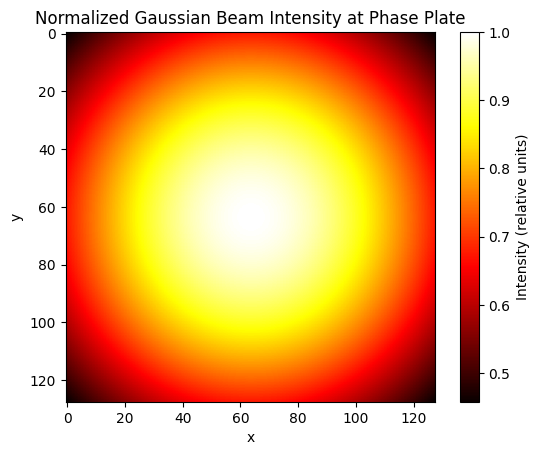

x_plate [-0.05       -0.0492126  -0.0484252  -0.0476378  -0.04685039]
X_plate [-0.05       -0.0492126  -0.0484252  -0.0476378  -0.04685039]


In [8]:
# Plot initial beam intensity, now normalized
plt.imshow(E_initial_intensity, cmap="hot")
plt.title("Normalized Gaussian Beam Intensity at Phase Plate")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Intensity (relative units)")
plt.show()

print("x_plate", x_plate[:5])
print("X_plate", X_plate[0, :5])

In [5]:
# from scipy.interpolate import interp2d

# def huygens_forward(E_phase_plate, X_plate, Y_plate, X_image, Y_image):
#     # Constants
#     k = 2 * np.pi / wavelength  # Wave number
    
#     # Initialize image plane electric field
#     E_image_plane = np.zeros((len(X_image), len(Y_image)), dtype=complex)
    
#     # Loop through each point in the image plane
#     for x_img_idx in range(len(X_image)):
#         for y_img_idx in range(len(Y_image)):
#             # Distance calculation for propagation from phase plate to each point in image plane
#             r = np.sqrt((X_image[x_img_idx, y_img_idx] - X_plate)**2 + 
#             (Y_image[x_img_idx, y_img_idx] - Y_plate)**2 + distance_plate_to_image**2 + epsilon)
#             E_contrib = (E_phase_plate / r) * np.exp(-1j * k * r)
            
#             # Sum contributions to get the electric field at this image plane point
#             E_image_plane[x_img_idx, y_img_idx] = np.sum(E_contrib)
    
#     return E_image_plane


In [6]:
# def apply_intensity_constraint(E_image_plane, target_intensity):
#     # Extract the phase from the current image plane field
#     phase_image_plane = np.angle(E_image_plane)
    
#     # Enforce the target intensity, keeping the phase
#     E_image_plane_constrained = target_intensity * np.exp(1j * phase_image_plane)
    
#     return E_image_plane_constrained


In [7]:
# def huygens_backward(E_image_plane, X_image, Y_image, X_plate, Y_plate):
#     # Constants
#     k = 2 * np.pi / wavelength  # Wave number
    
#     # Initialize phase plate electric field
#     E_phase_plate = np.zeros((len(X_plate), len(Y_plate)), dtype=complex)
    
#     # Loop through each point on the phase plate
#     for x_plate_idx in range(len(X_plate)):
#         for y_plate_idx in range(len(Y_plate)):
#             # Distance calculation for propagation from image plane to each point on phase plate
#             r = np.sqrt((X_plate[x_plate_idx, y_plate_idx] - X_image)**2 + 
#                         (Y_plate[x_plate_idx, y_plate_idx] - Y_image)**2 + distance_plate_to_image**2 + epsilon)
#             E_contrib = (E_image_plane / r) * np.exp(-1j * k * r)
            
#             # Sum contributions to get the electric field at this phase plate point
#             E_phase_plate[x_plate_idx, y_plate_idx] = np.sum(E_contrib)
    
#     return E_phase_plate


In [5]:
 # Define a function for Omega (phase or angular modulation)
def calculate_omega(rr, distance):
    # Ensure rr >= distance to avoid invalid cosine values
    rr = np.maximum(rr, distance)
    cos_omega = distance / rr
    omega = np.arccos(np.clip(cos_omega, -1.0, 1.0))
    return omega

# Huygens-Fresnel propagation with interference
def propagate_with_interference(E_input, X_source, Y_source, X_target, Y_target, distance):
    k = 2 * np.pi / wavelength  # Wave number
    E_out = np.zeros((len(X_target), len(Y_target)), dtype=complex)

    # pixel_size_plate = plate_size / grid_size
    # pixel_size_image = image_size / grid_size_image

    # print(pixel_size_plate ,"and" ,pixel_size_image)
    
    for ix in range(len(X_source)):
        for iy in range(len(Y_source)):
            # r = np.sqrt(((X_target * pixel_size_image) - (X_source[ix, iy] * pixel_size_plate))**2 + 
            #             ((Y_target * pixel_size_image) - (Y_source[ix, iy] * pixel_size_plate))**2 + distance**2)
            epsilon_r = 1e-6 
            r = np.sqrt((X_target - X_source[ix, iy])**2 + 
                        (Y_target - Y_source[ix, iy])**2 + distance**2)
            # r = np.maximum(r, epsilon_r)
            omega = calculate_omega(r, distance)
            
            # Calculate contribution with angular modulation
            E_d = (np.abs(E_input[ix, iy]) / r) * np.exp(-1j * k * r + 1j * np.angle(E_input[ix, iy]))
            E_out += E_d * (1 + np.cos(omega))

            # print(r)
    
    return E_out

def back_propagate_with_interference(E_input, X_source, Y_source, X_target, Y_target, distance):
    k = 2 * np.pi / wavelength  # Wave number
    E_out = np.zeros((len(X_target), len(Y_target)), dtype=complex)

    # pixel_size_plate = plate_size / grid_size
    # pixel_size_image = image_size / grid_size_image

    # print(pixel_size_plate ,"and" ,pixel_size_image)
    
    for ix in range(len(X_source)):
        for iy in range(len(Y_source)):
            # r = np.sqrt(((X_target * pixel_size_plate) - (X_source[ix, iy] * pixel_size_image))**2 + 
            #             ((Y_target * pixel_size_plate) - (Y_source[ix, iy] * pixel_size_image))**2 + distance**2)
            epsilon_r = 1e-6 
            r = np.sqrt((X_target - X_source[ix, iy])**2 + 
                        (Y_target - Y_source[ix, iy])**2 + distance**2)
            # r = np.maximum(r, epsilon_r)
            omega = calculate_omega(r, distance)
            
            # Calculate contribution with angular modulation
            E_d = (np.abs(E_input[ix, iy]) / r) * np.exp(-1j * k * r + 1j * np.angle(E_input[ix, iy]))
            E_out += E_d * (1 + np.cos(omega))

            # print(r)
    
    return E_out

In [6]:
# Define target image grid (500x500 mm)
image_size = 0.1  # Target image size in meters (500 mm x 500 mm)
grid_size_image = 60  # Larger grid for image plane
x_image = np.linspace(-image_size/2, image_size/2, grid_size_image)
y_image = np.linspace(-image_size/2, image_size/2, grid_size_image)
X_image, Y_image = np.meshgrid(x_image, y_image)

In [7]:
# Define target intensity profile on the 500x500 mm grid (same as paper)
target_size_x = 10e-3   # Target size in x-direction (384 mm)
target_size_y = 90e-3  # Target size in y-direction (6 mm)
# target_size_x = 100e-3   # Target size in x-direction (384 mm)
# target_size_y = 100e-3  # Target size in y-direction (6 mm)
target_intensity = np.zeros((grid_size_image, grid_size_image))
target_x = (np.abs(X_image) <= target_size_x / 2)
target_y = (np.abs(Y_image) <= target_size_y / 2)
target_intensity[target_x & target_y] = 1

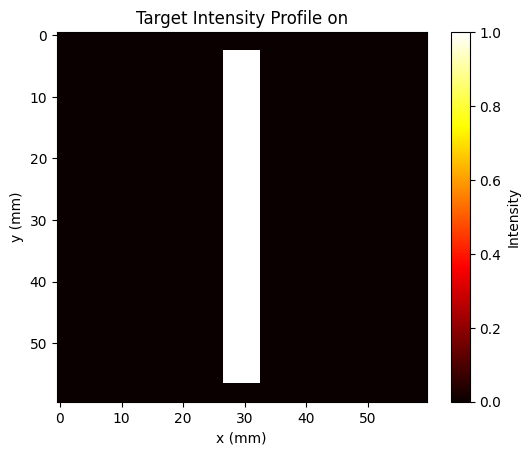

In [8]:
# Plot target intensity profile
plt.imshow(target_intensity, cmap="hot")
plt.title("Target Intensity Profile on")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity")
plt.show()

In [9]:
# # Initialize random phase profile on phase plate
# phase_profile = np.exp(1j * np.random.rand(grid_size, grid_size) * 2 * np.pi)

# # Gerchberg-Saxton Iterations (scaled to accommodate both grids)
# num_iterations = 50
# for i in range(num_iterations):
#     # Step 1: Forward propagation from 100x100 mm phase plate to 500x500 mm image plane
#     # Here, interpolate or scale as needed to match grid size differences
#     E_image_plane = huygens_forward(E_initial * phase_profile, X_plate, Y_plate, X_image, Y_image)

#     # Step 2: Apply target intensity constraint in the 500x500 mm image plane
#     E_image_plane = apply_intensity_constraint(E_image_plane, target_intensity)
    
#     # Step 3: Backward propagation from 500x500 mm image plane to 100x100 mm phase plate
#     E_phase_plate = huygens_backward(E_image_plane, X_image, Y_image, X_plate, Y_plate)
    
#     # Step 4: Update phase profile on the 100x100 mm phase plate grid
#     phase_profile = np.exp(1j * np.angle(E_phase_plate))

In [10]:
# # # Initialize random phase profile on phase plate
# phase_profile = np.ones((grid_size, grid_size), dtype=complex)

# # Set error threshold (e.g., 10% target error)
# error_threshold = 0.10  # 10% error

# # Initialize variables
# max_iterations = 20  # Maximum iterations to avoid infinite loops
# error = float('inf')  # Initialize error to a large number
# iteration = 0  # Initialize iteration counter

# # Gerchberg-Saxton Iterations with Error-Based Stopping
# # error > error_threshold and
# while iteration < max_iterations:
#     # Step 1: Forward propagation from 100x100 mm phase plate to 500x500 mm image plane
#     E_image_plane = huygens_forward(E_initial * phase_profile, X_plate, Y_plate, X_image, Y_image, distance_plate_to_image)

#     # Calculate intensity in the image plane
#     intensity_image_current = np.abs(E_image_plane)**2

#     # Step 2: Calculate error between current intensity and target intensity
#     # Adding a small epsilon to prevent division by zero
#     epsilon = 1e-10
#     # 
#     error = np.mean(np.abs(intensity_image_current - target_intensity)) / (np.mean(target_intensity) + epsilon)
#     print(f"Iteration {iteration}: Error = {error:.4f}")

#     # Step 3: Check if error is within acceptable range
#     if error <= error_threshold:
#         print(f"Convergence achieved with error {error:.4f} at iteration {iteration}")
#         break

#     # Step 4: Apply target intensity constraint in the image plane
#     E_image_plane = apply_intensity_constraint(E_image_plane, target_intensity)
    
#     # Step 5: Backward propagation from 500x500 mm image plane to 100x100 mm phase plate
#     E_phase_plate = huygens_backward(E_image_plane, X_image, Y_image, X_plate, Y_plate, distance_plate_to_image)
    
#     # Step 6: Update phase profile on the 100x100 mm phase plate grid
#     phase_profile = np.exp(1j * np.angle(E_phase_plate))
    
#     # Update iteration count
#     iteration += 1

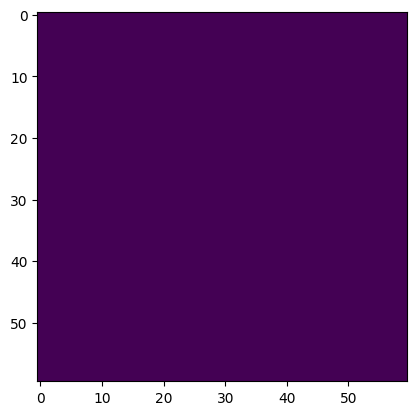

In [9]:
# # Step 1: Take the Fourier transform of the target intensity
# target_ft = np.fft.fft2(target_intensity)
# target_ft_shifted = np.fft.fftshift(target_ft)  # Shift zero frequency to center

# # Step 2: Resize or crop if necessary to match the phase plate size
# # Here, let's assume cropping to the phase plate size
# target_ft_resized = target_ft_shifted[:grid_size, :grid_size]

# # Step 3: Apply the inverse Fourier transform
# initial_input = np.fft.ifft2(np.fft.ifftshift(target_ft_resized))

# # Normalize the initial input intensity and phase
# E_initial = np.abs(initial_input) * np.exp(1j * np.angle(initial_input))
# targetft = propagate_with_interference(target_intensity, X_image, Y_image, X_plate, Y_plate, distance_plate_to_image)
        
# # Step 4: Update the phase at the phase plate (keep initial amplitude, update phase)
# targetangle = np.angle(targetft)
# E_initial = np.abs(E_initial_intensity) * np.exp(1j * targetangle)

plt.imshow(np.angle(E_initial))
plt.show()

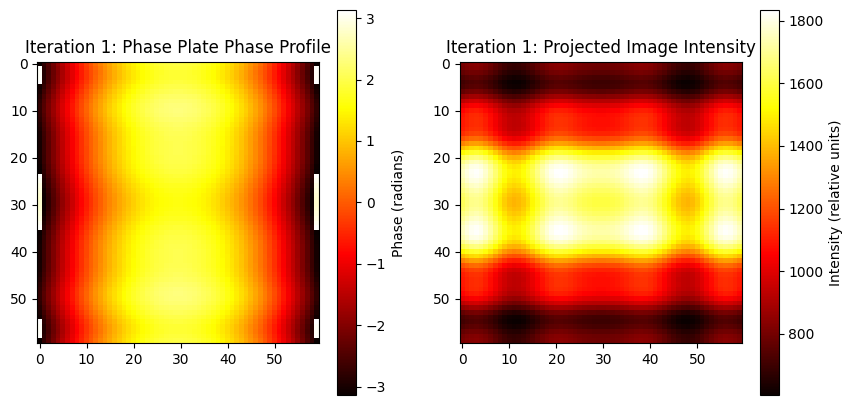

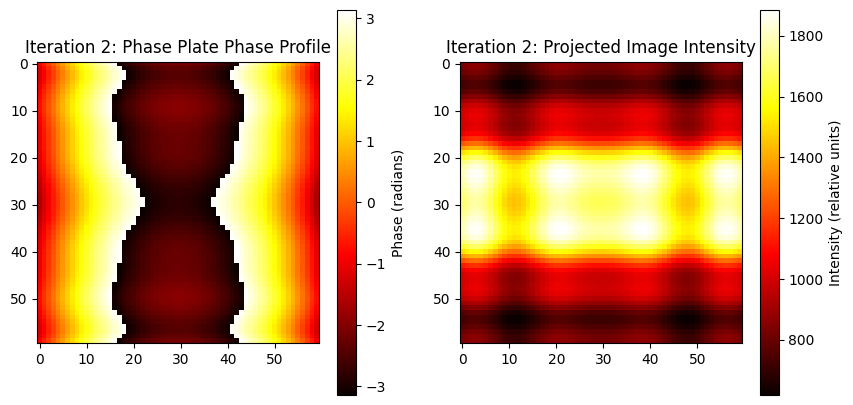

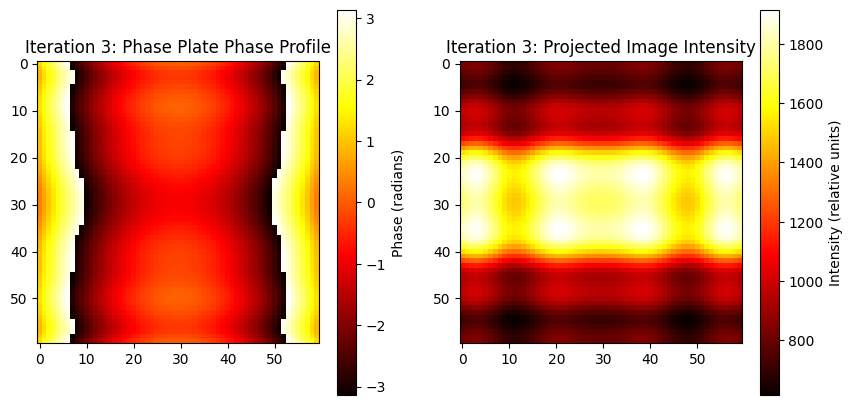

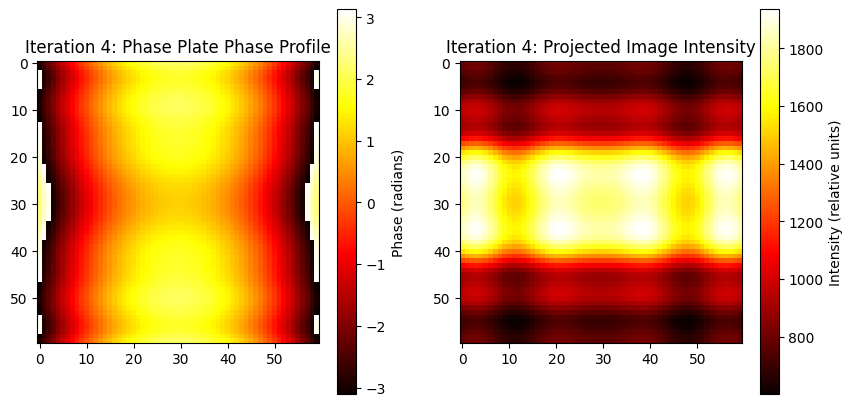

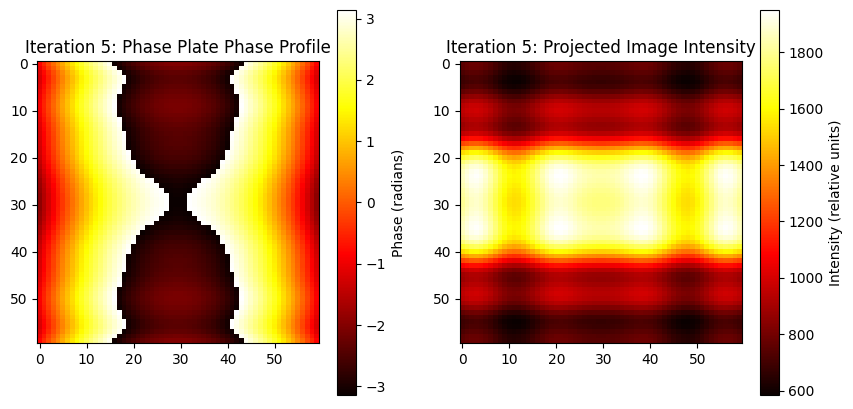

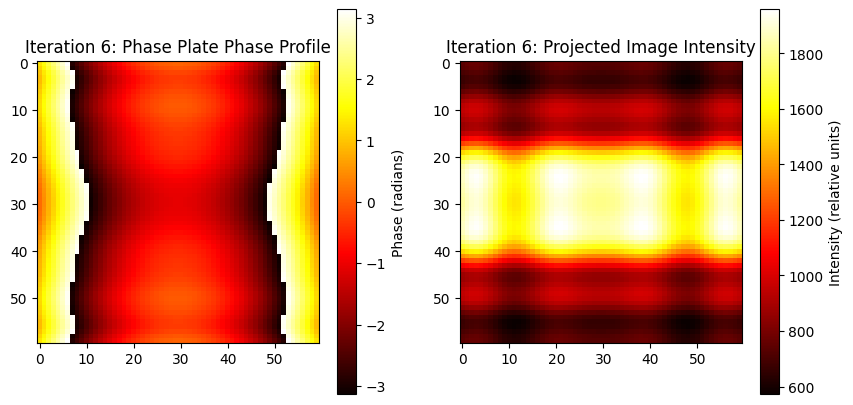

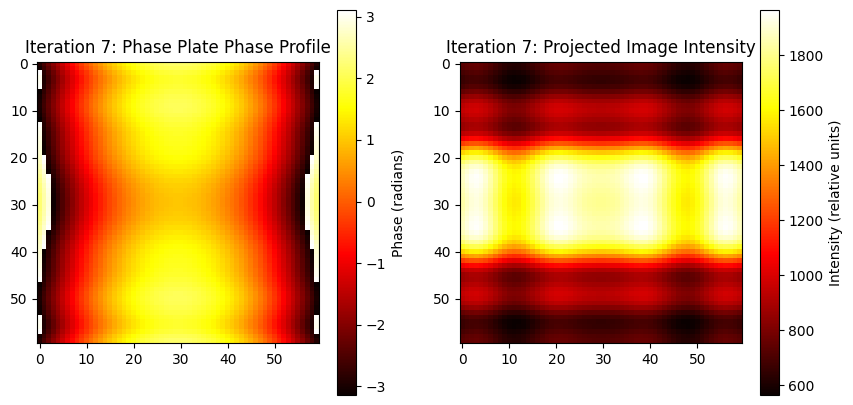

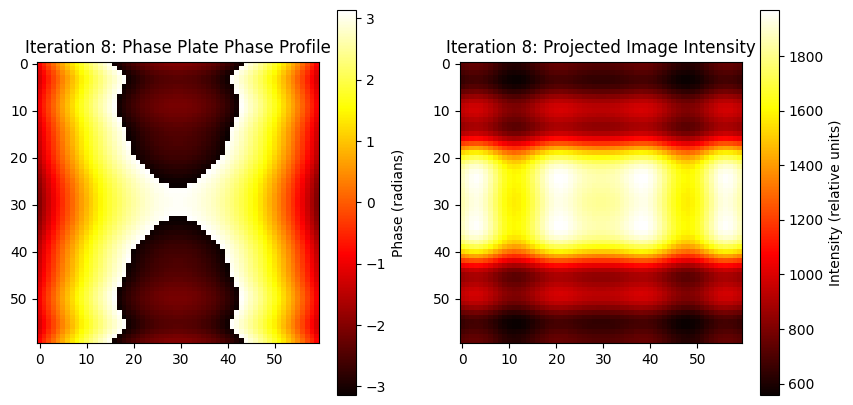

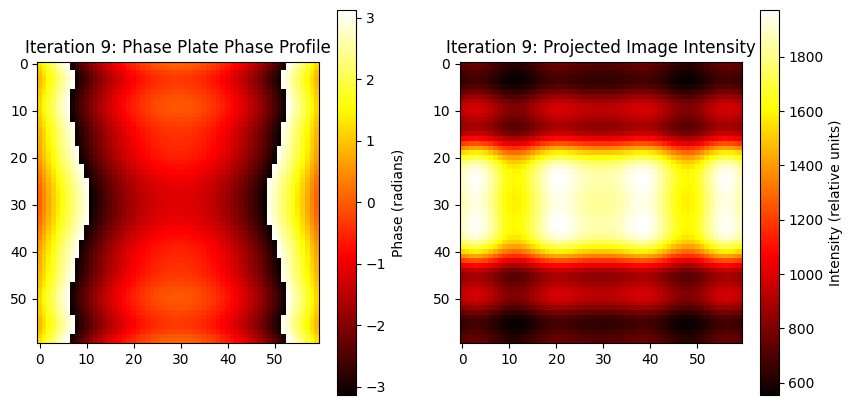

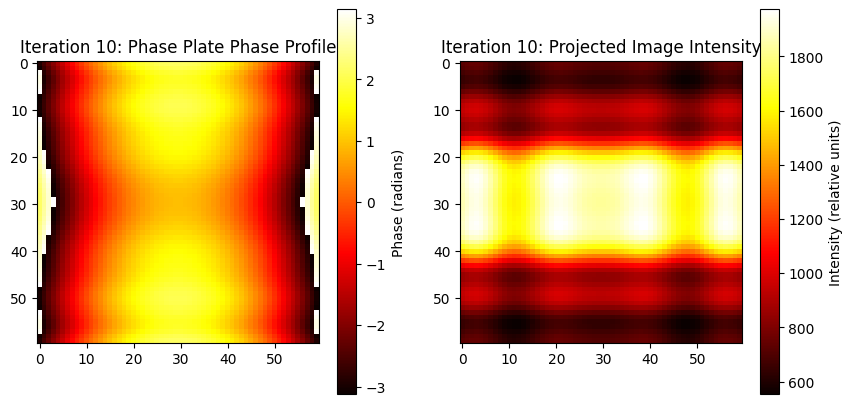

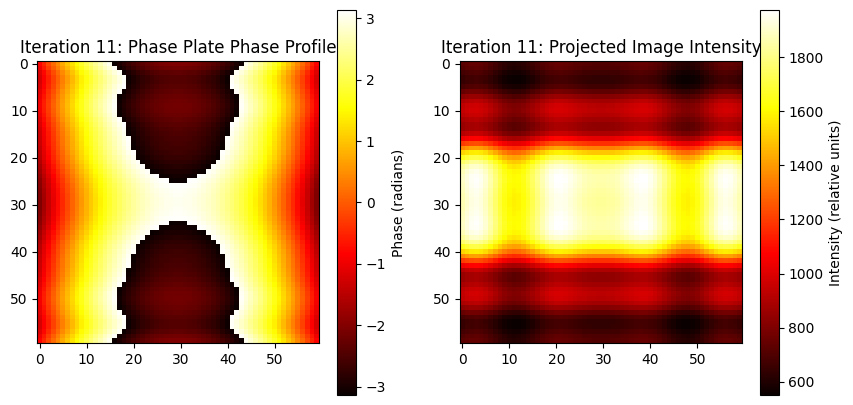

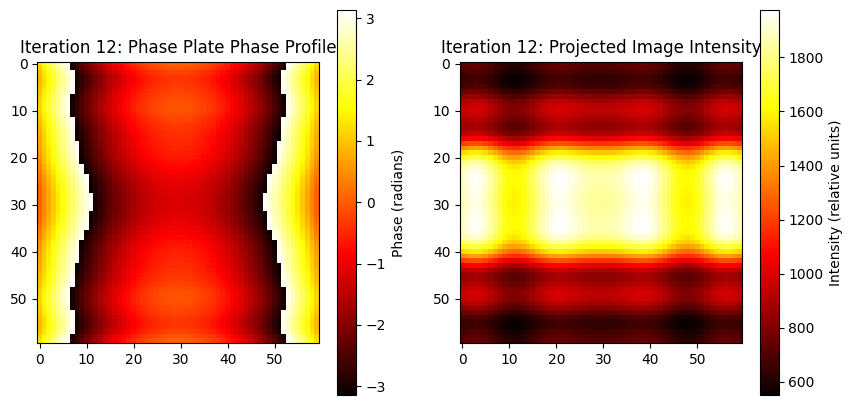

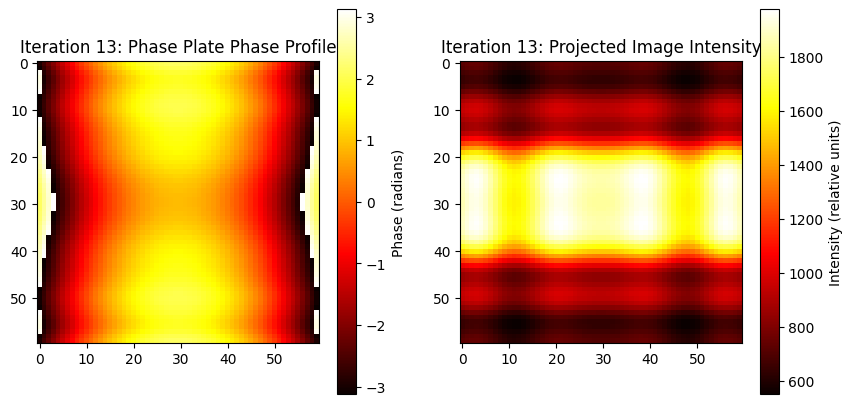

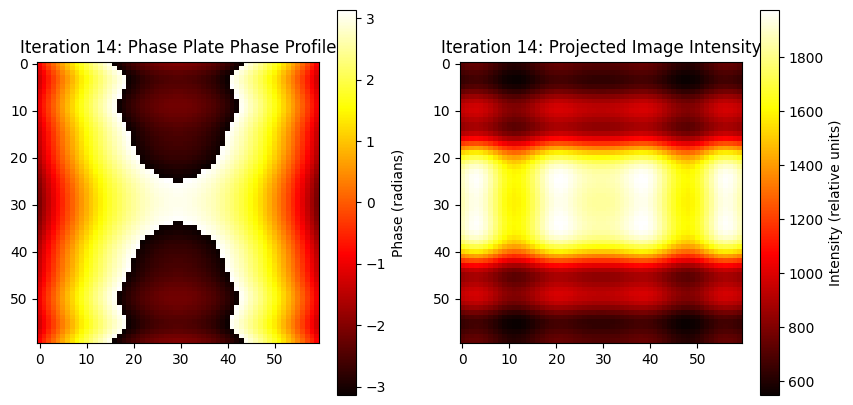

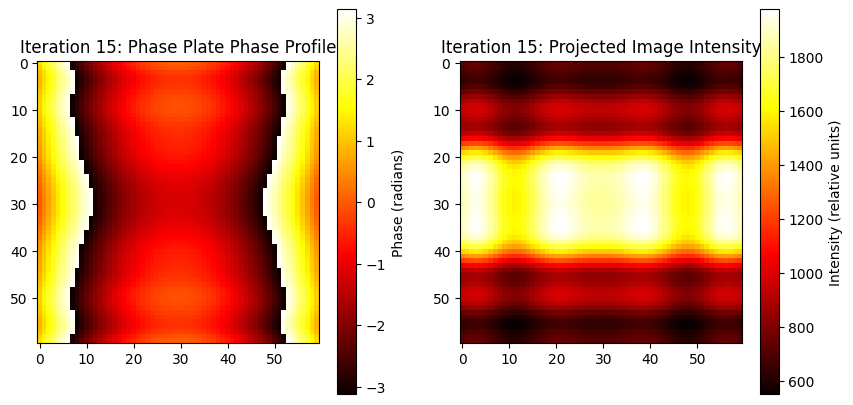

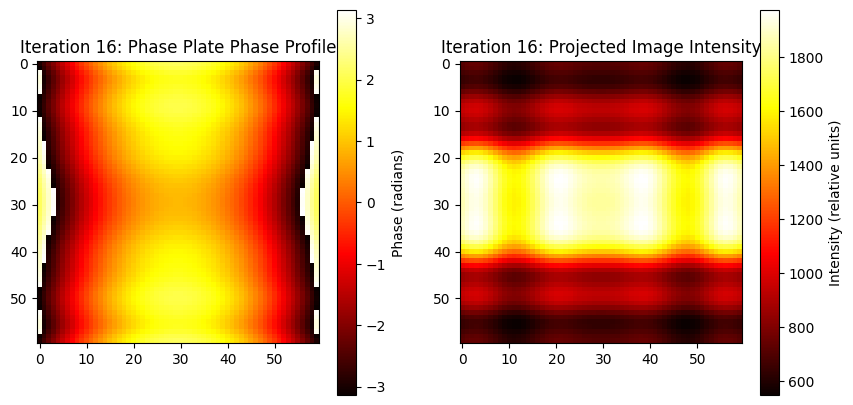

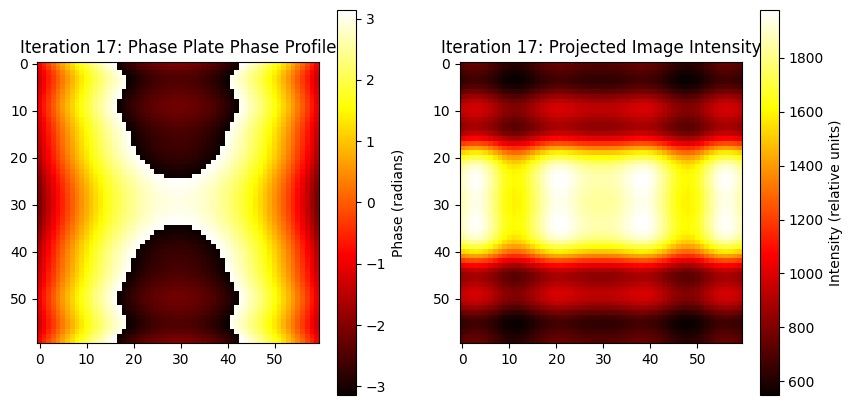

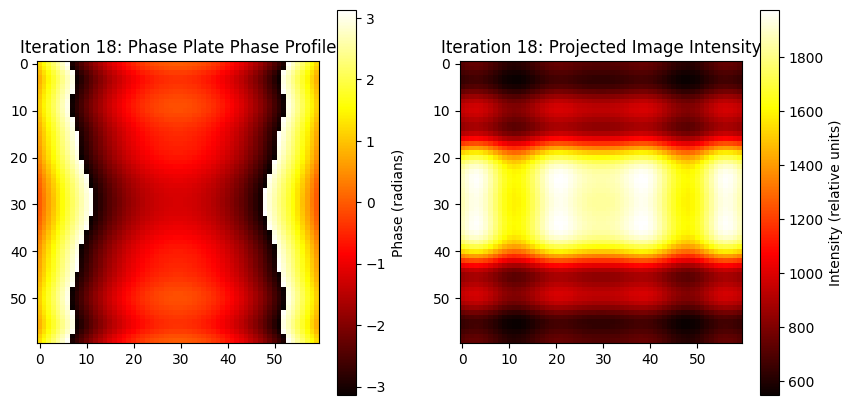

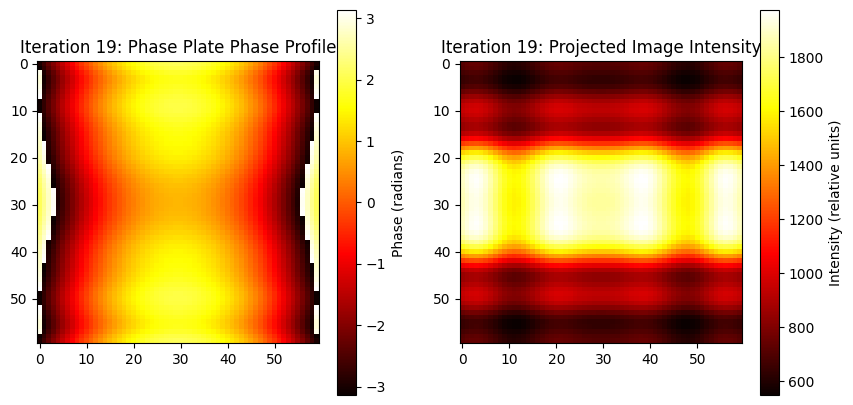

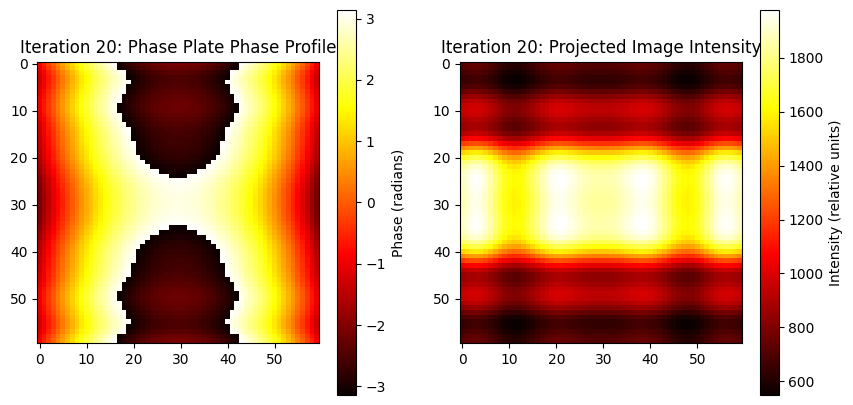

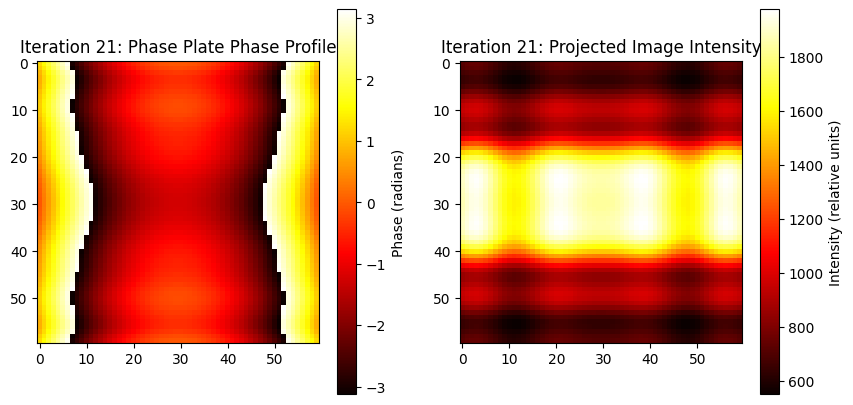

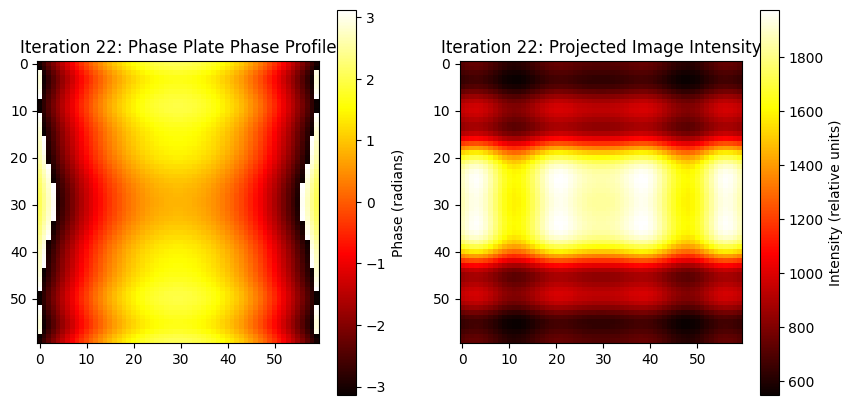

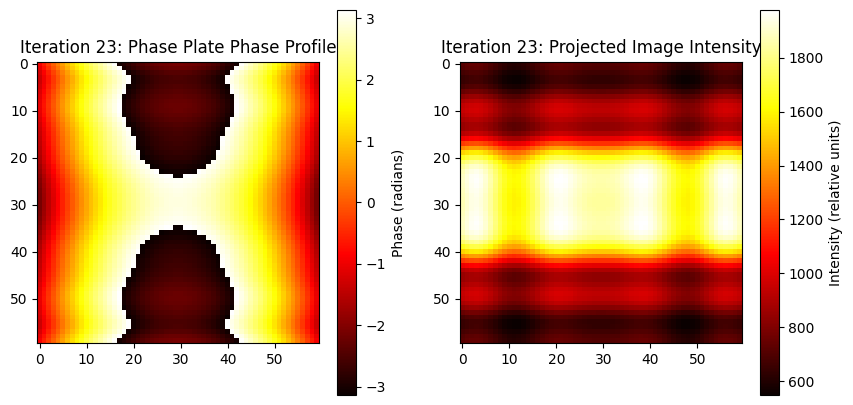

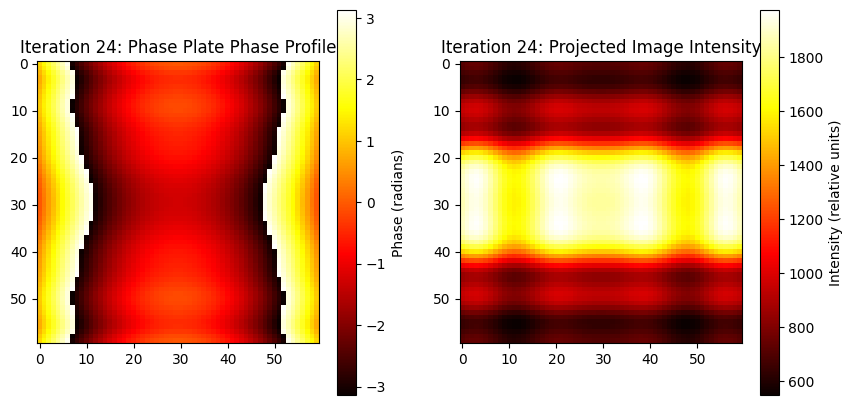

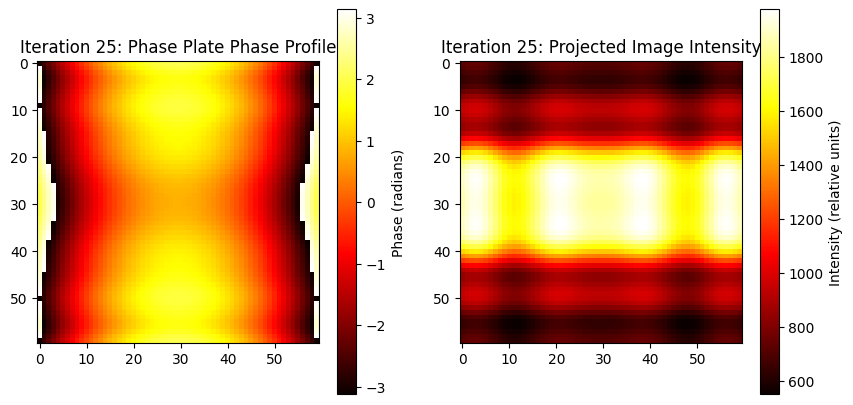

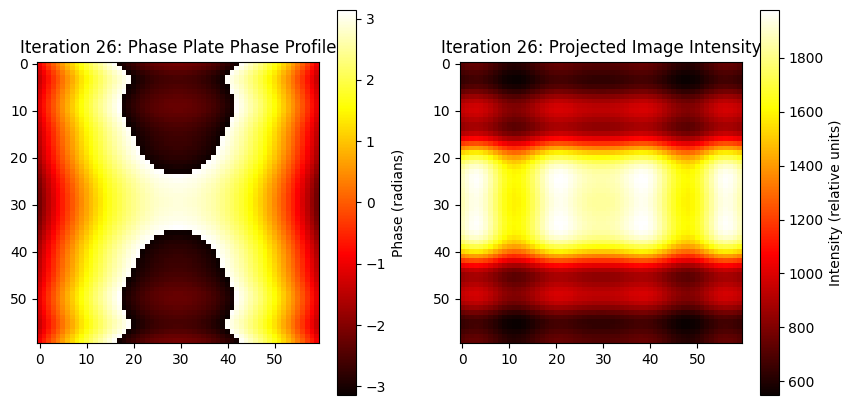

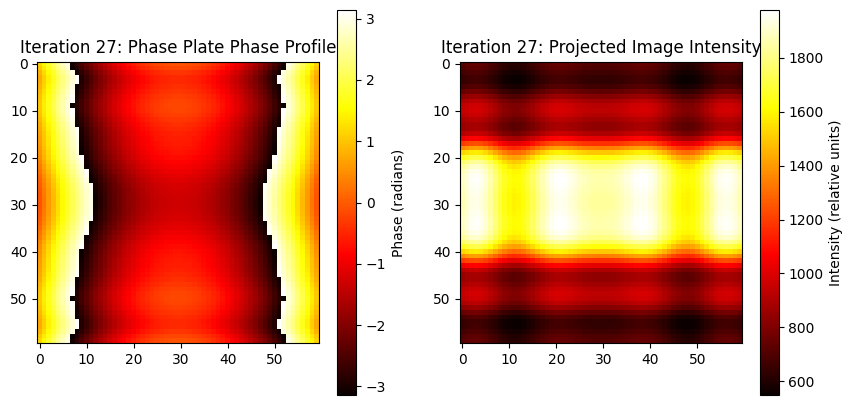

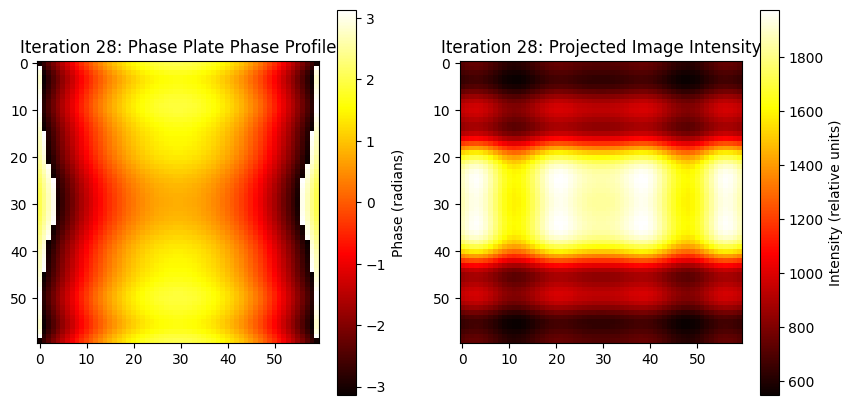

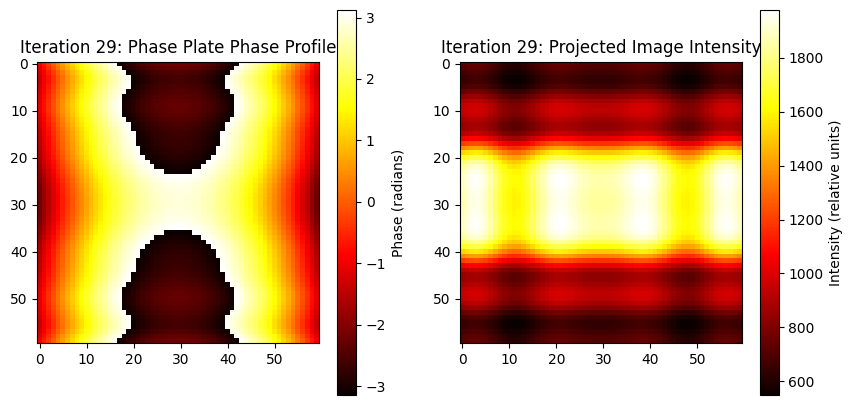

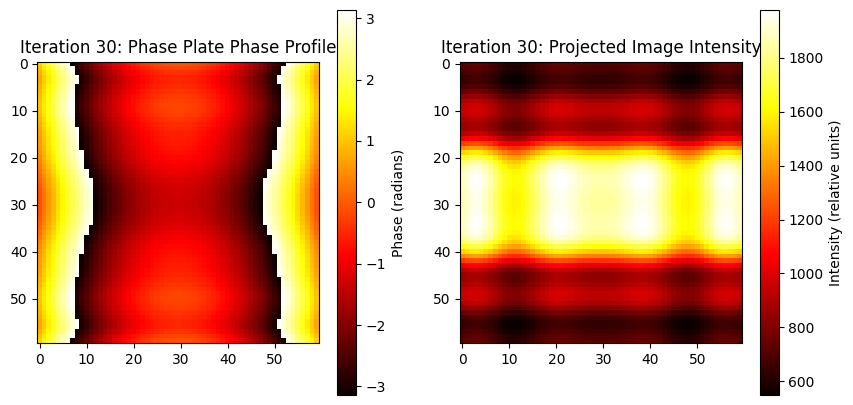

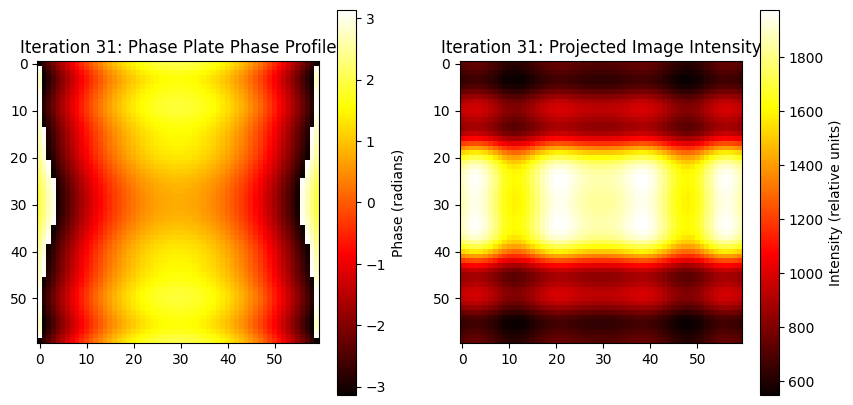

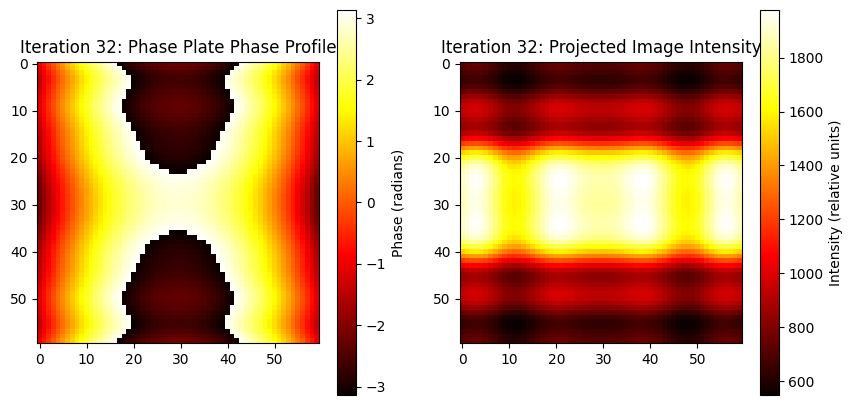

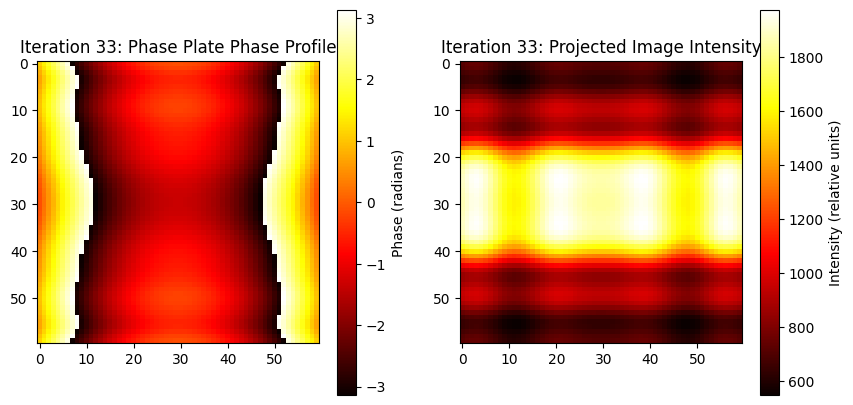

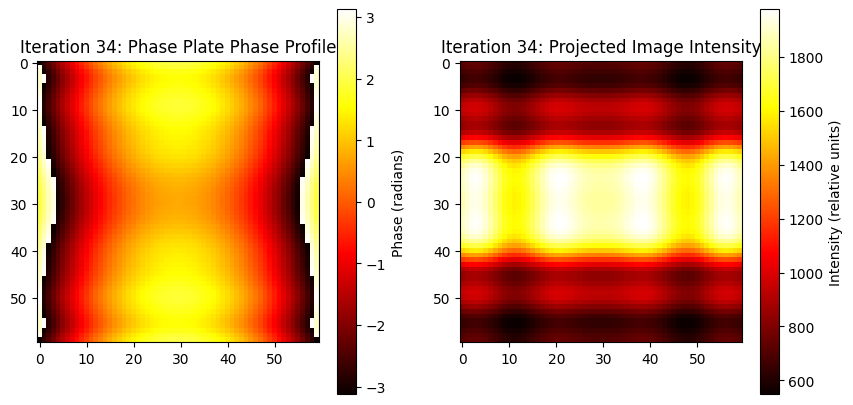

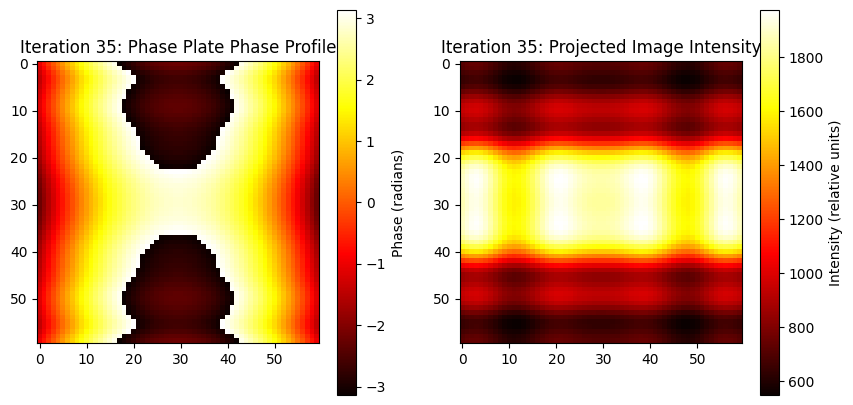

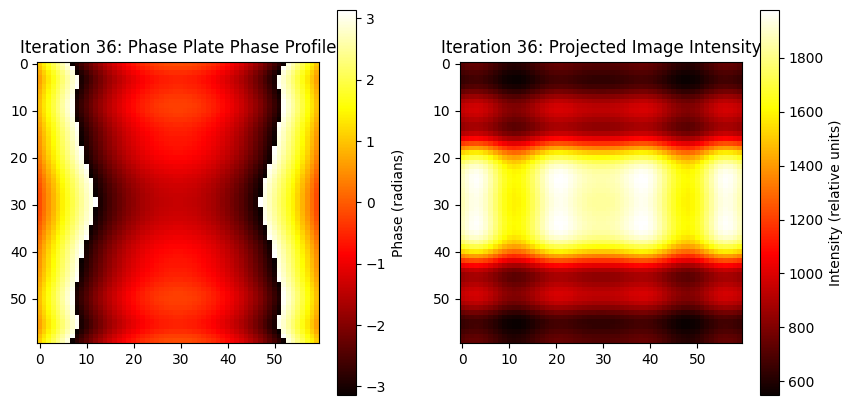

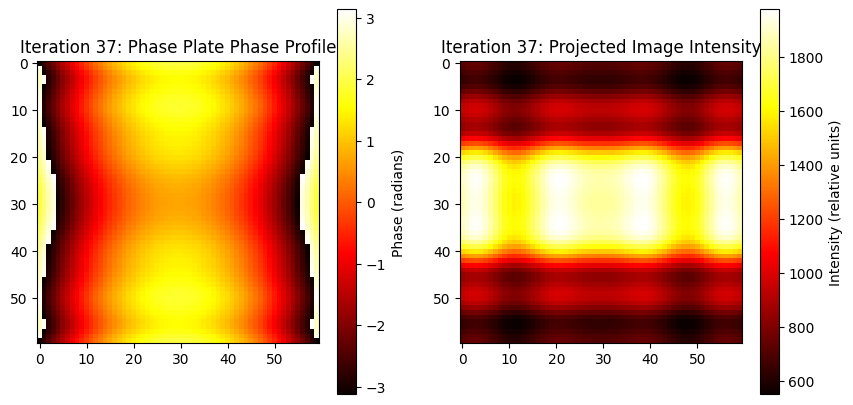

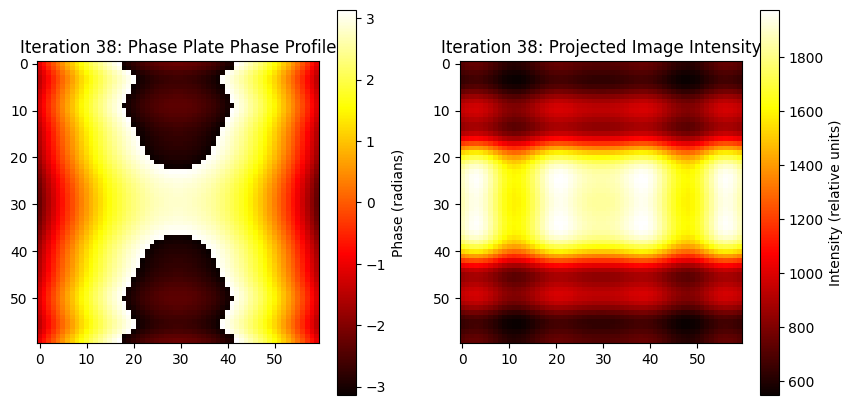

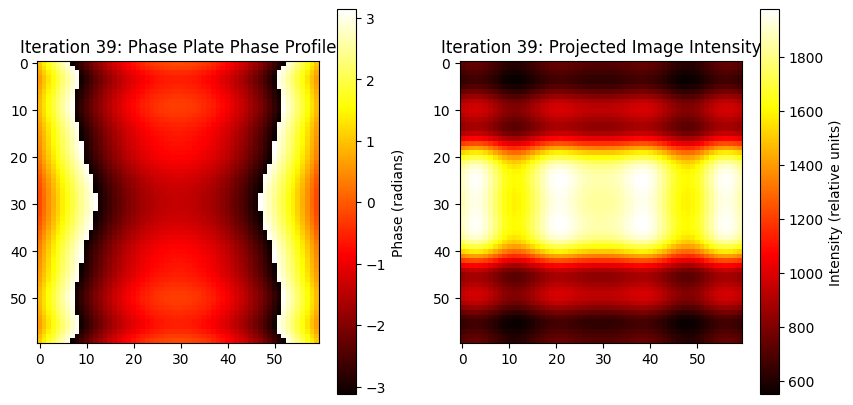

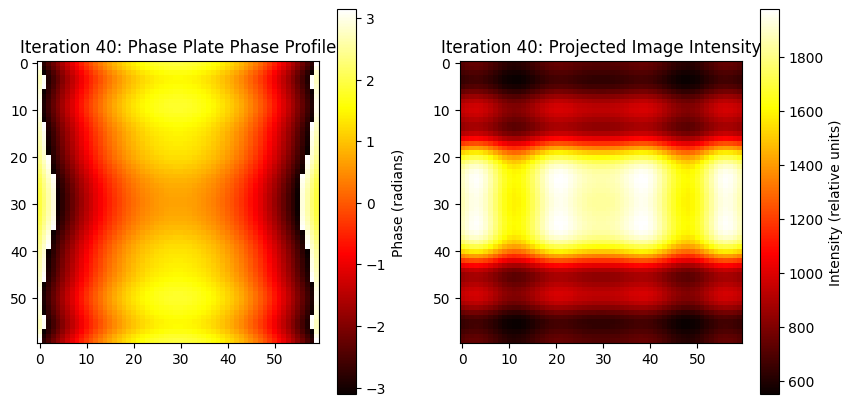

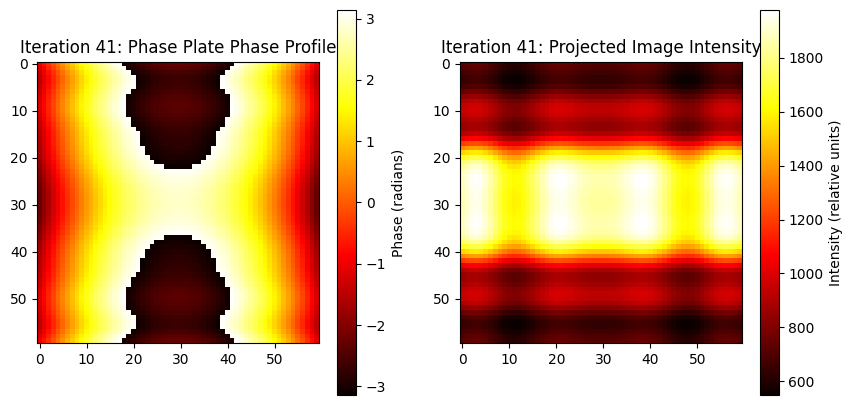

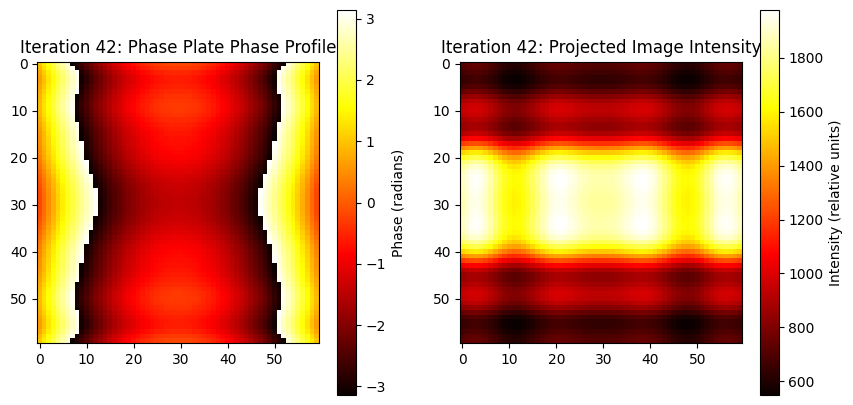

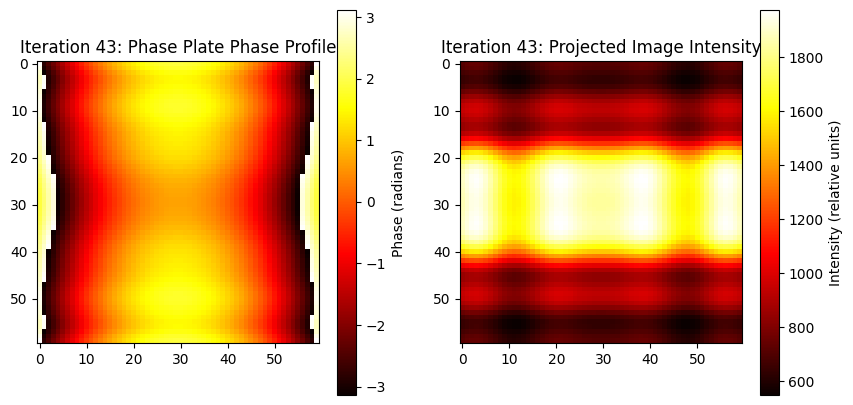

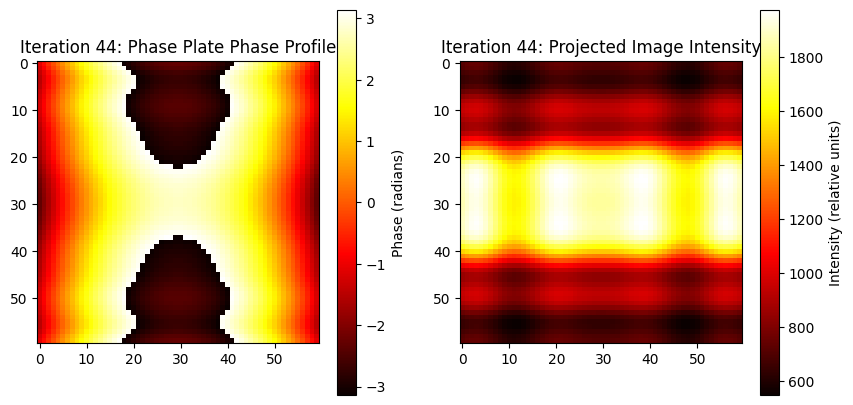

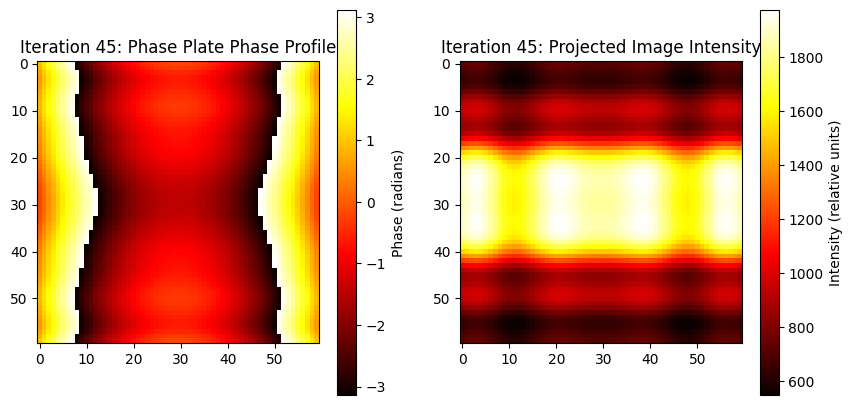

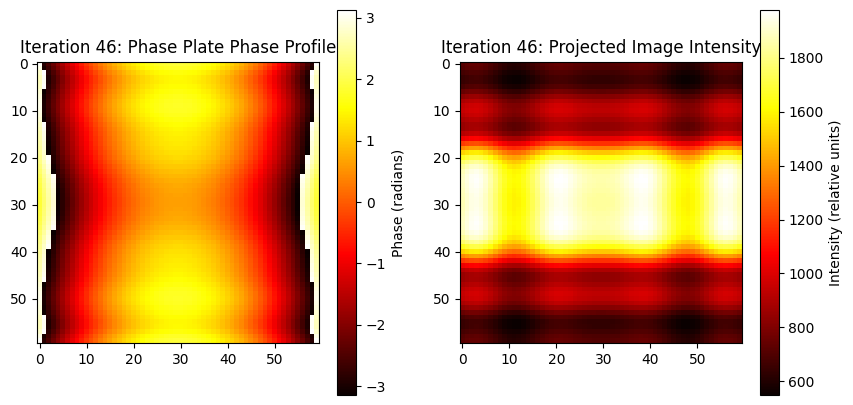

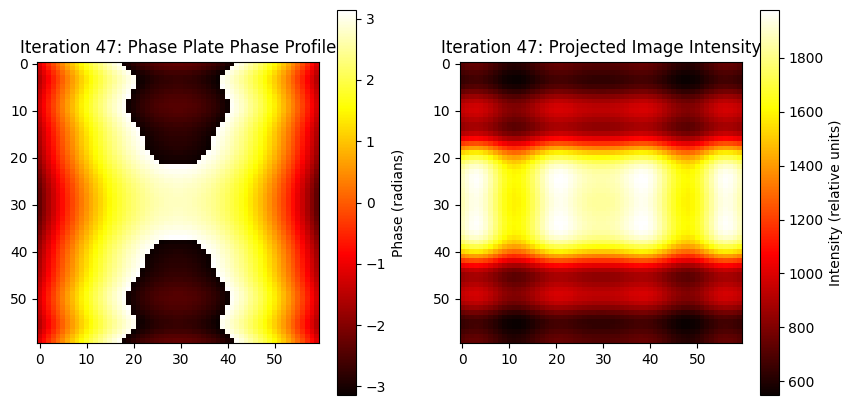

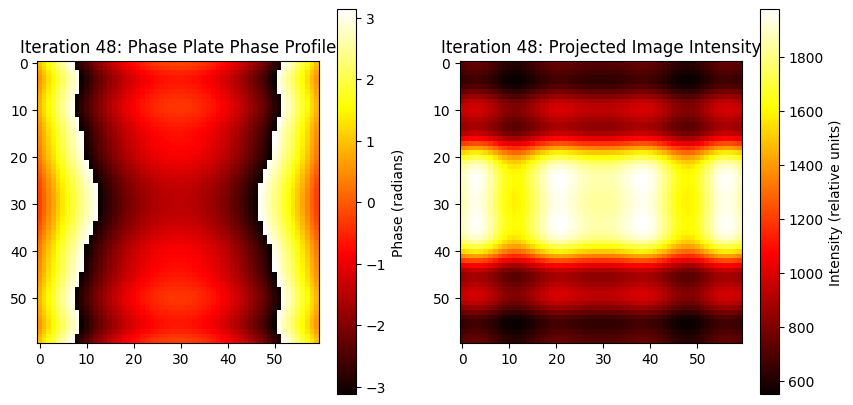

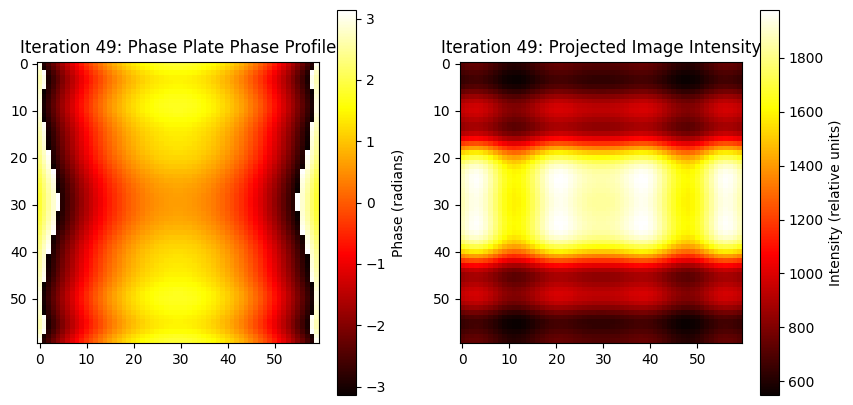

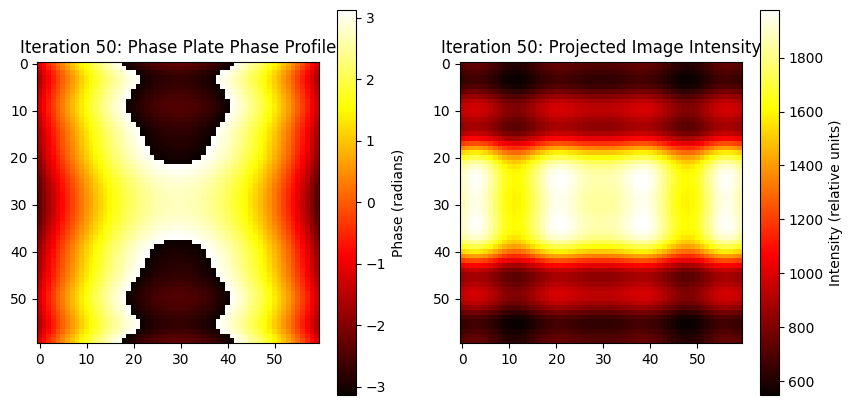

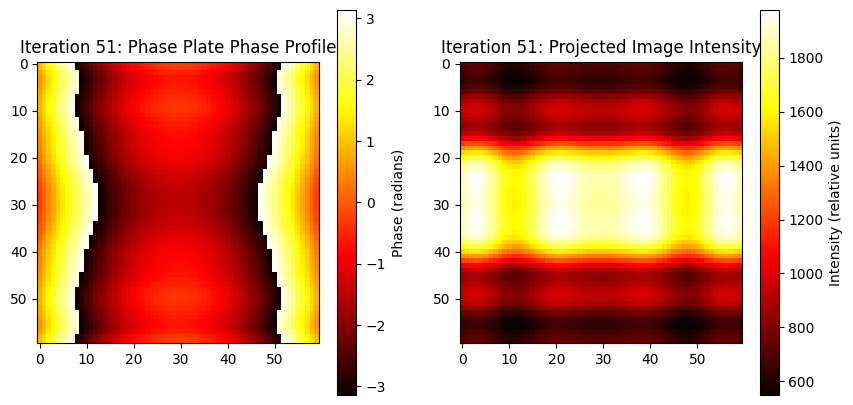

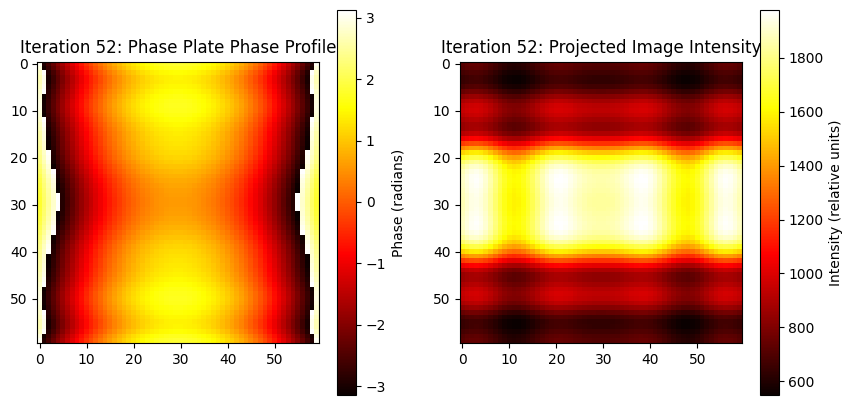

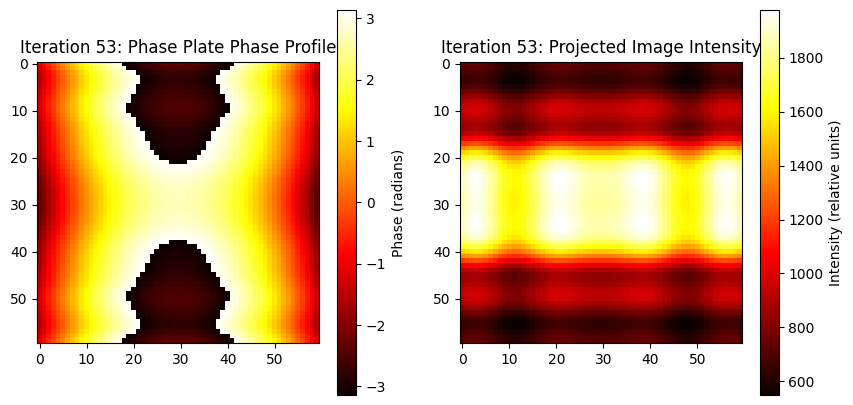

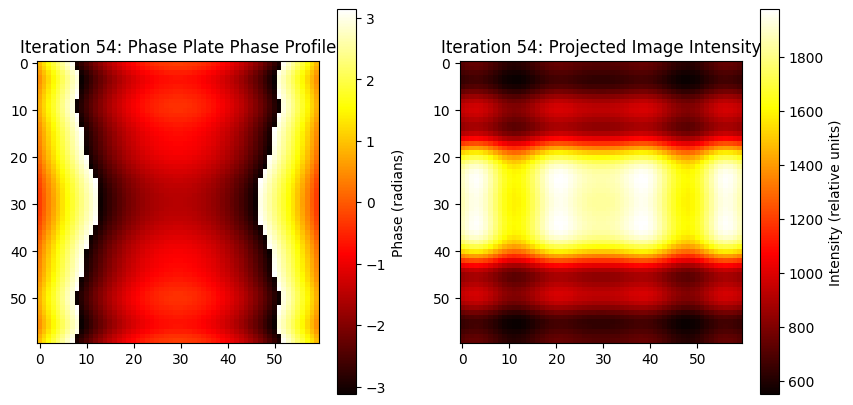

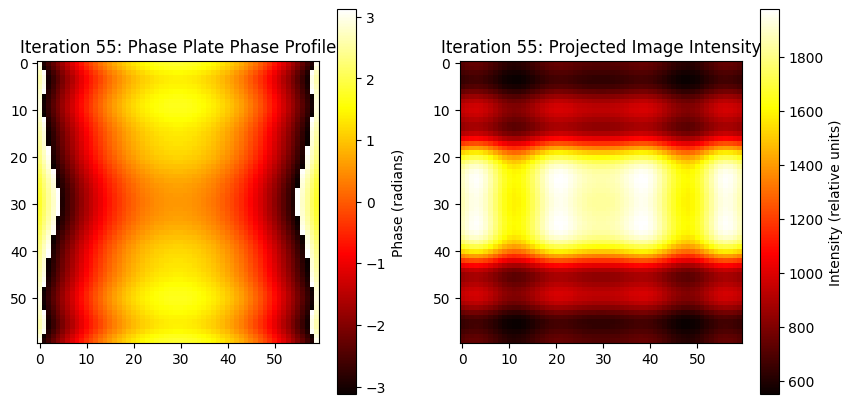

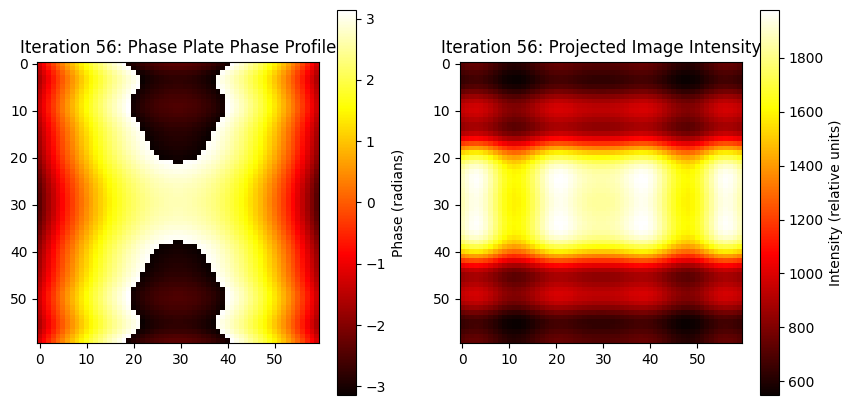

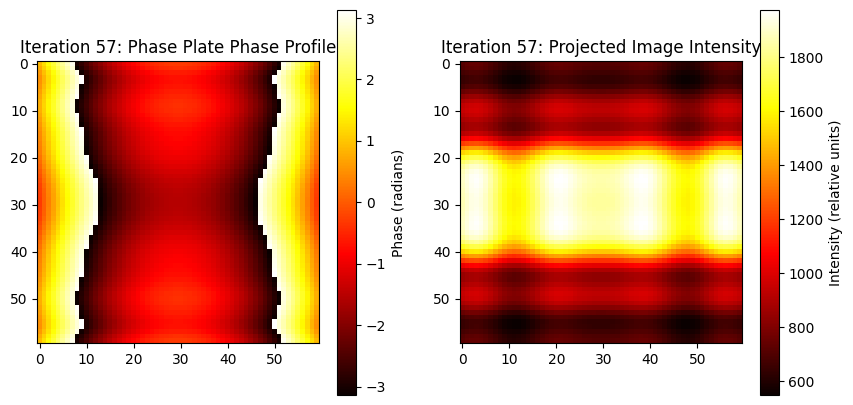

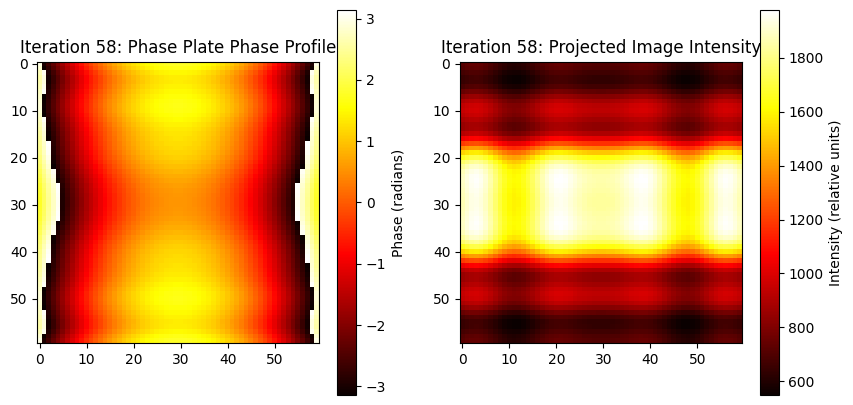

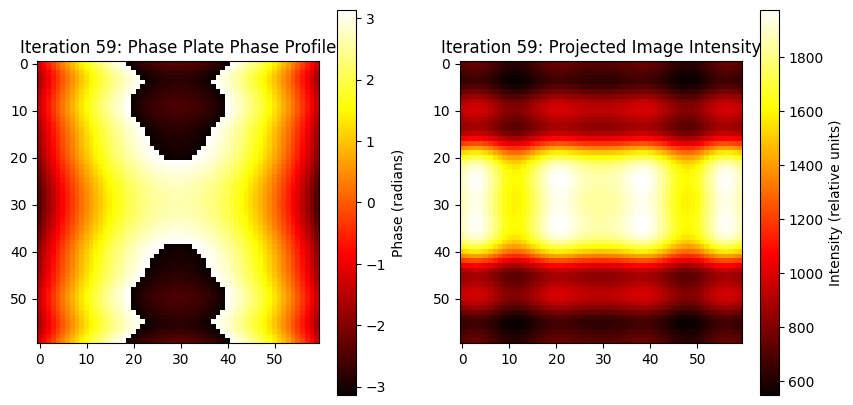

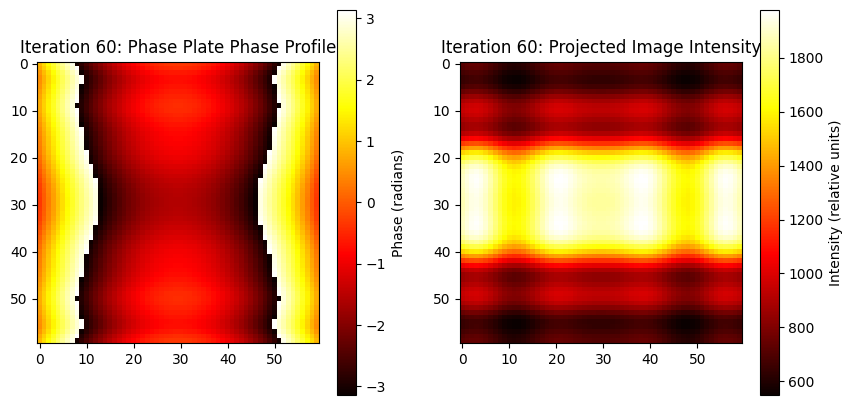

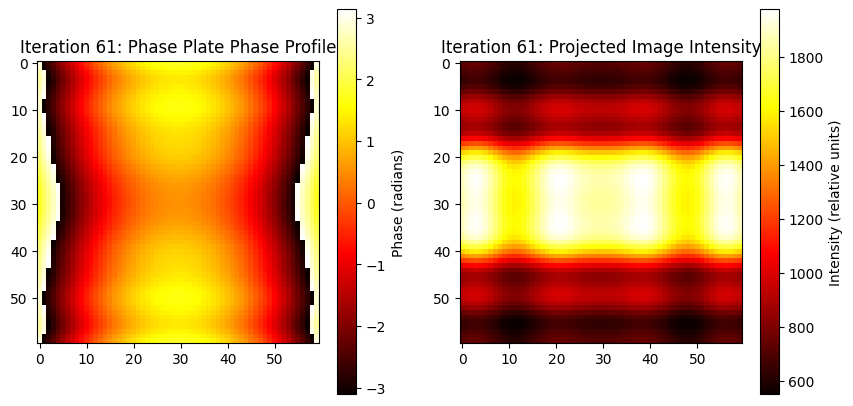

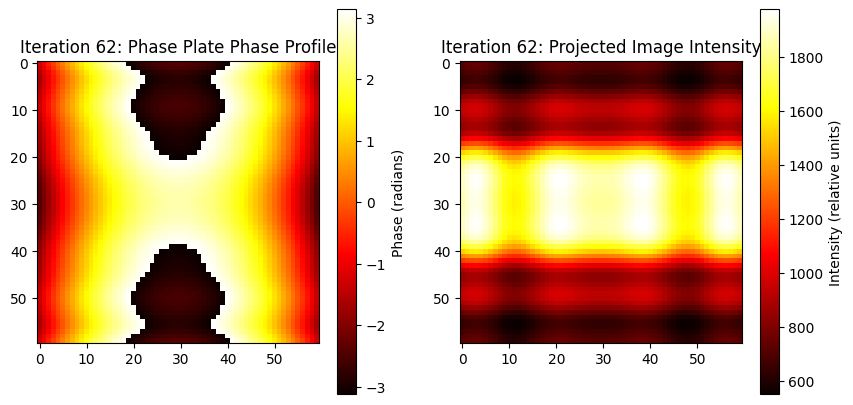

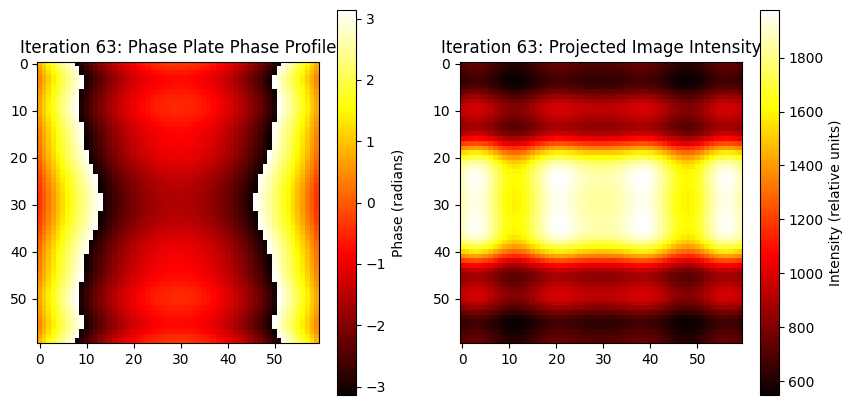

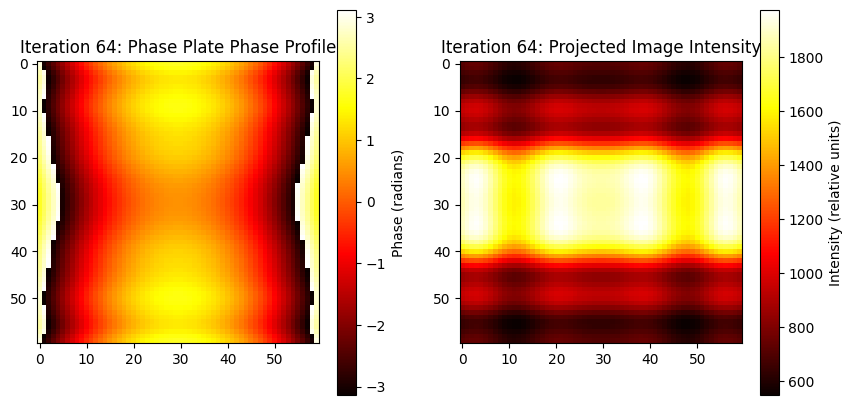

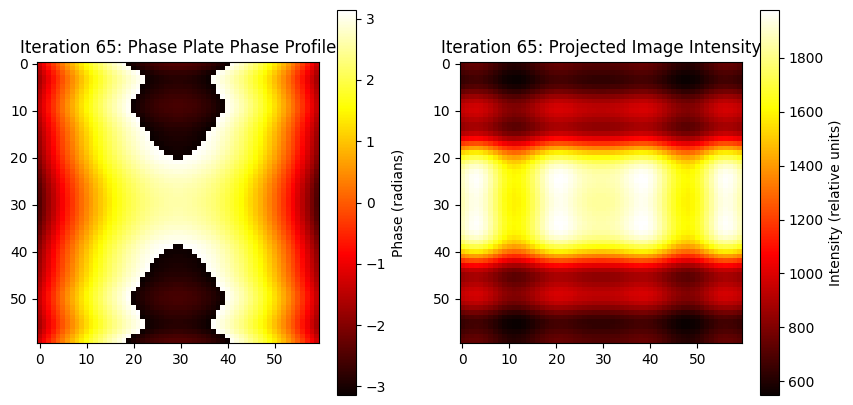

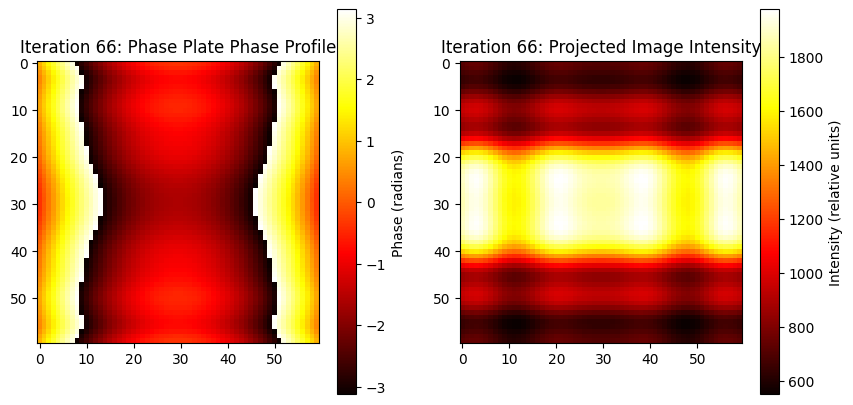

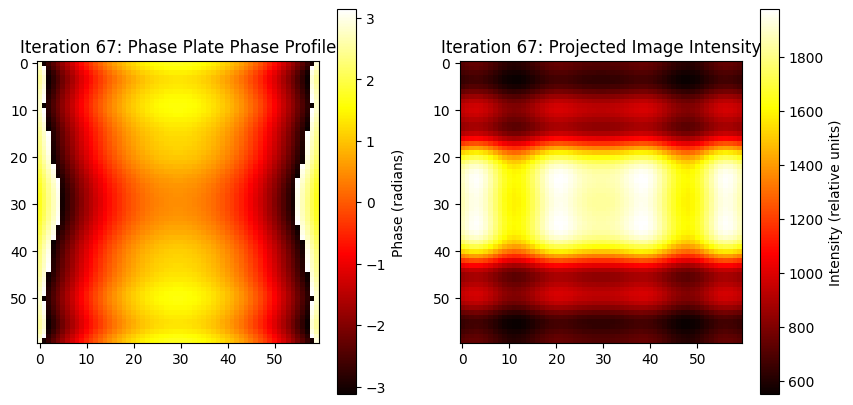

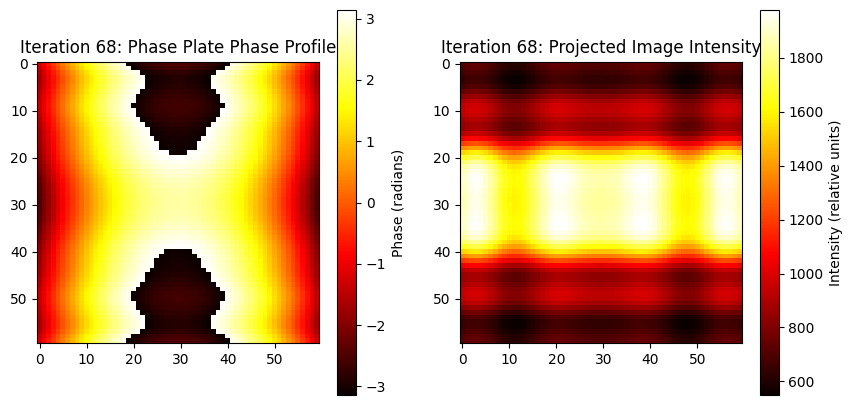

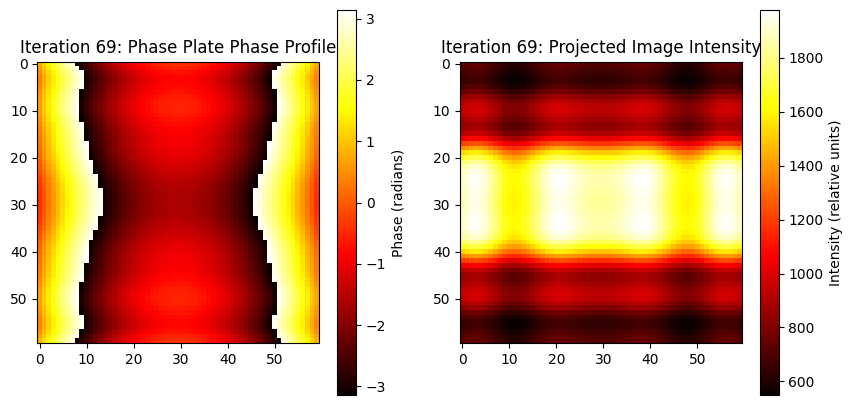

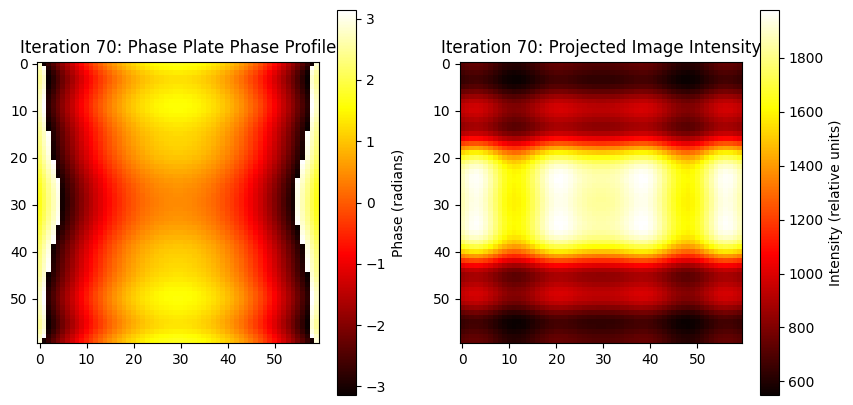

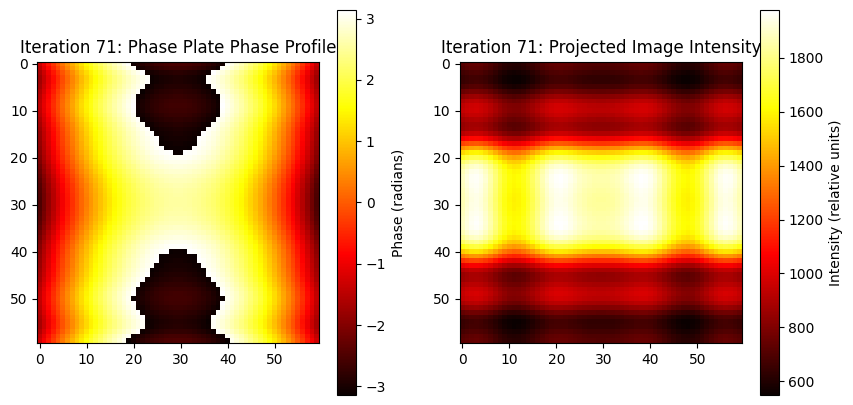

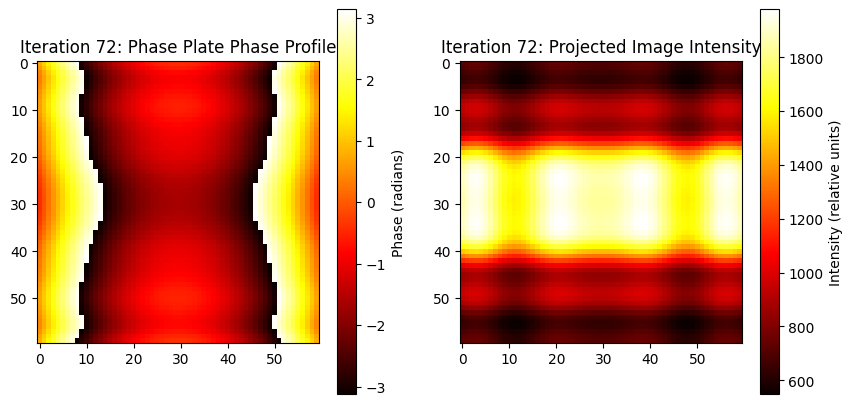

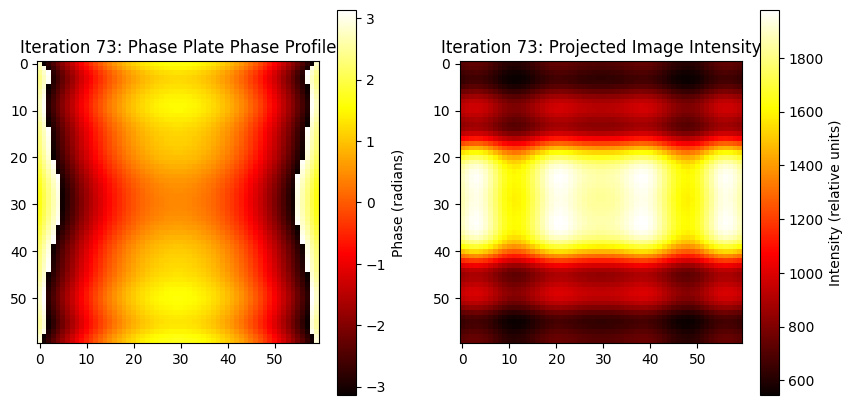

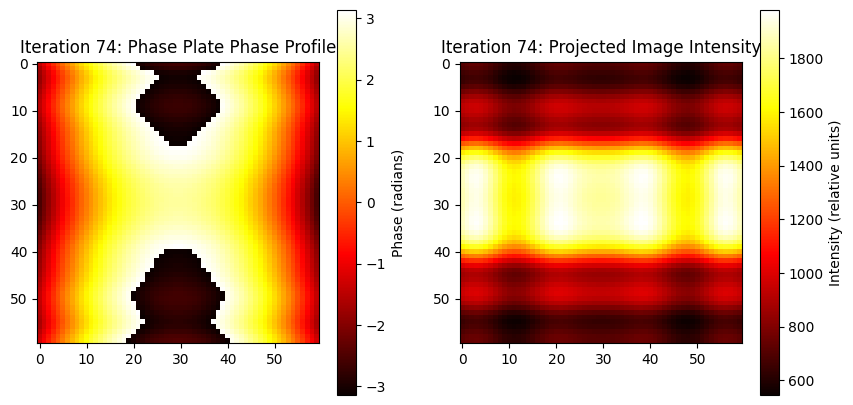

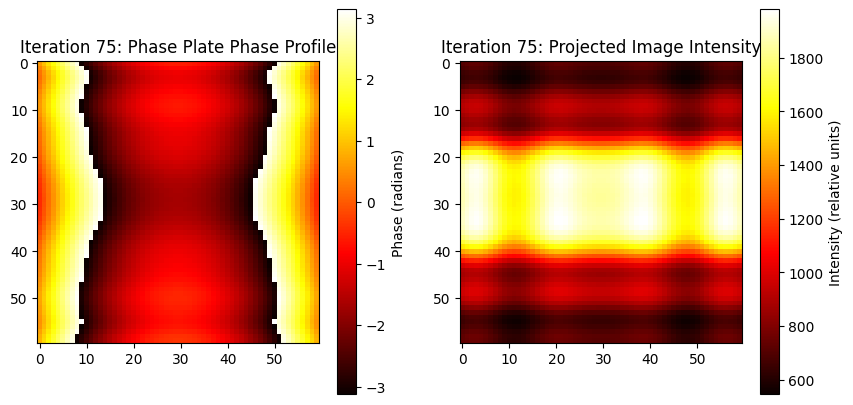

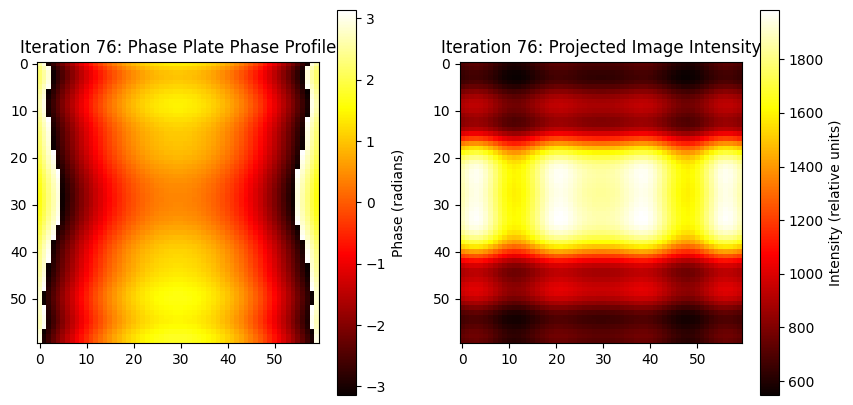

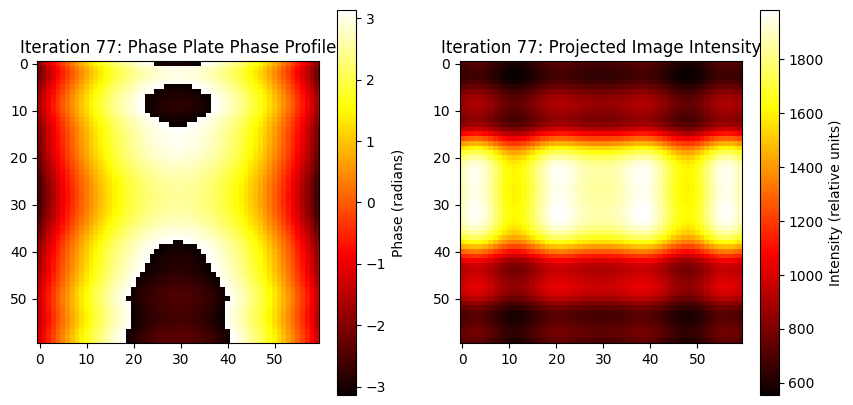

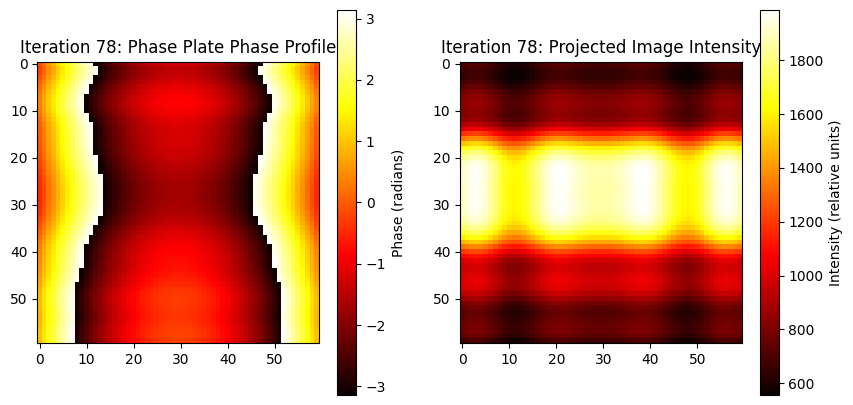

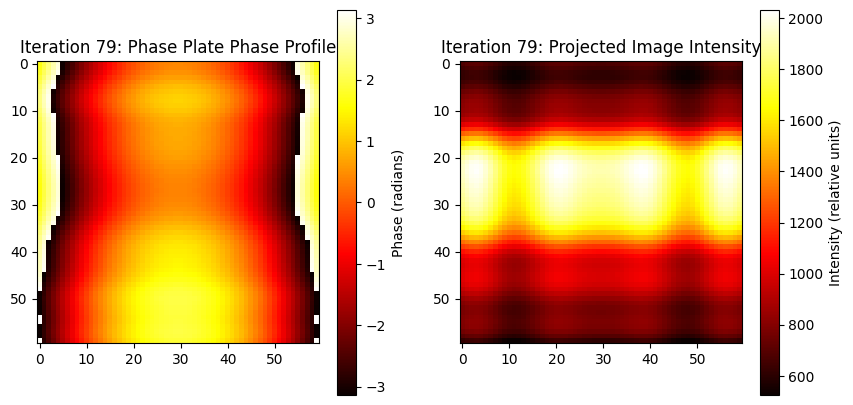

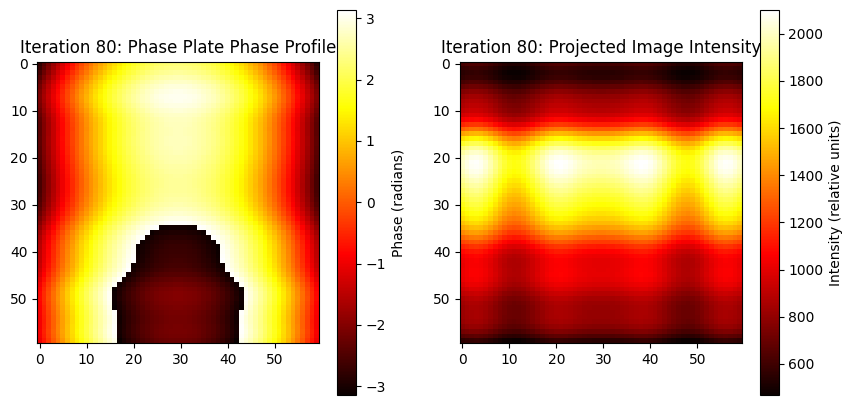

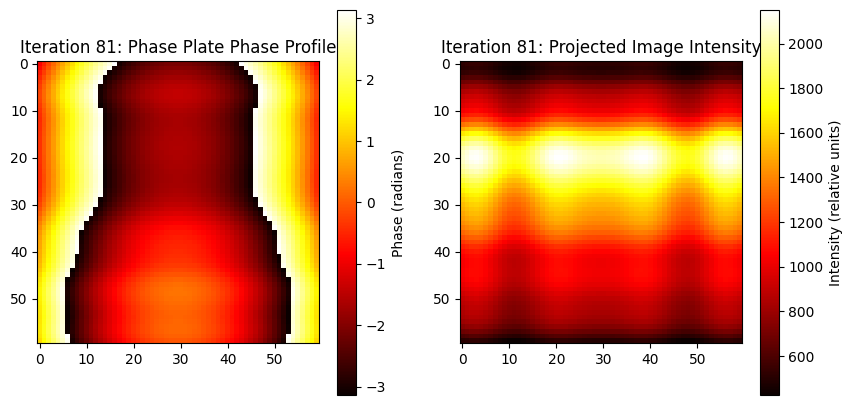

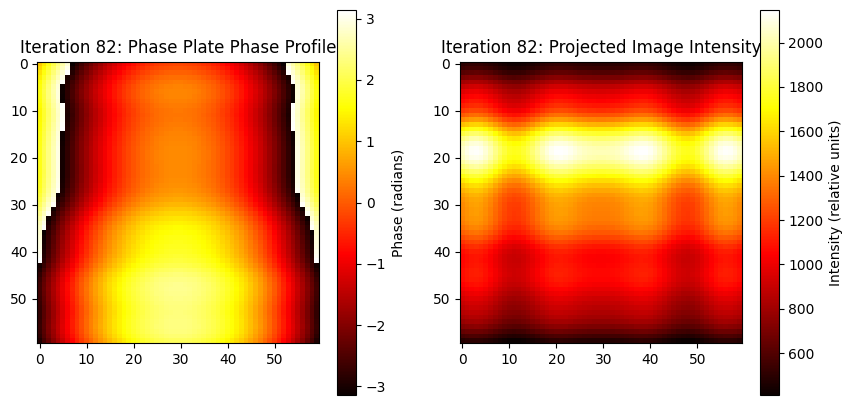

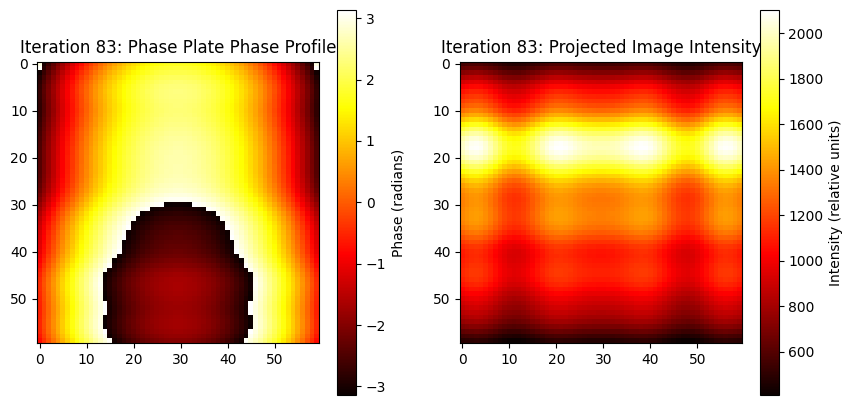

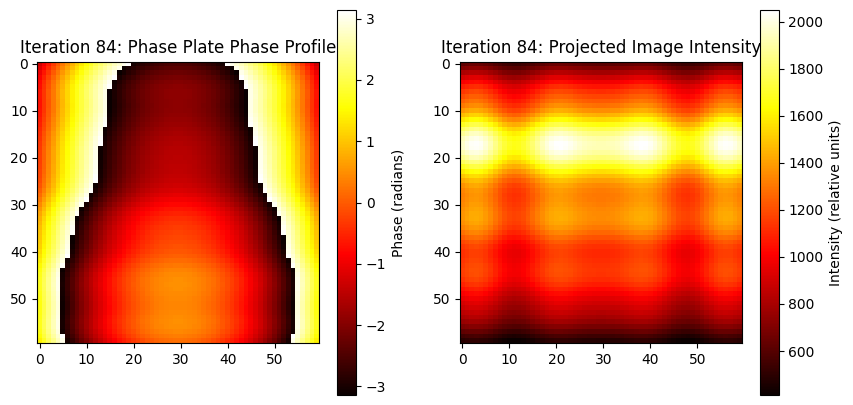

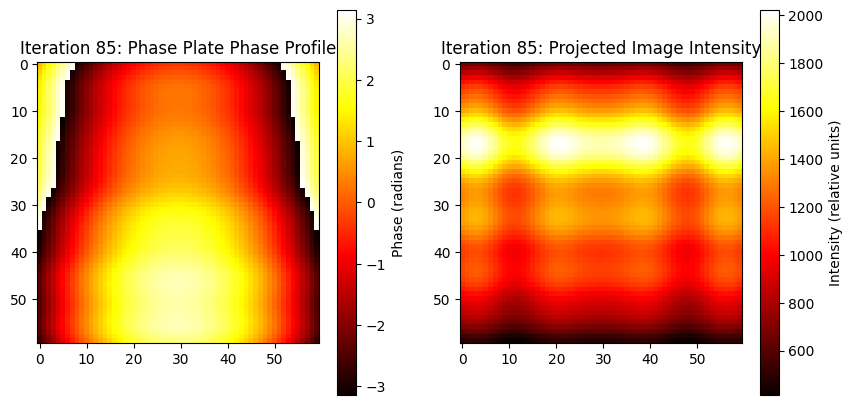

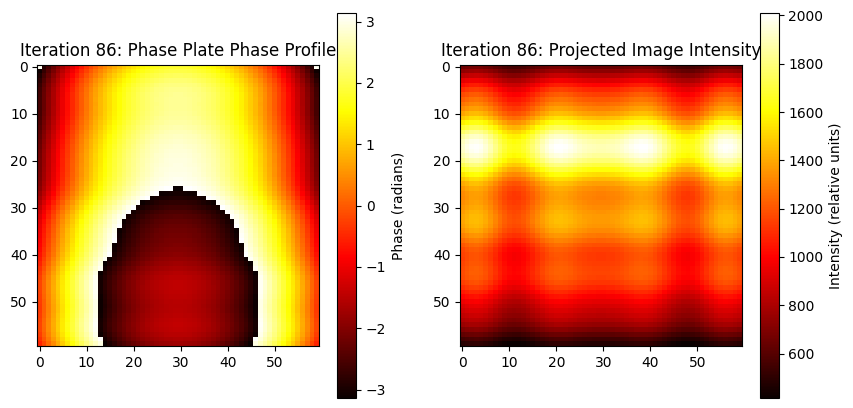

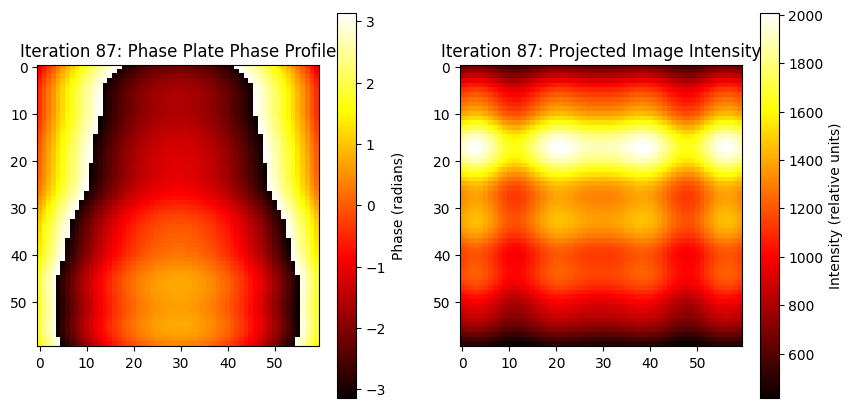

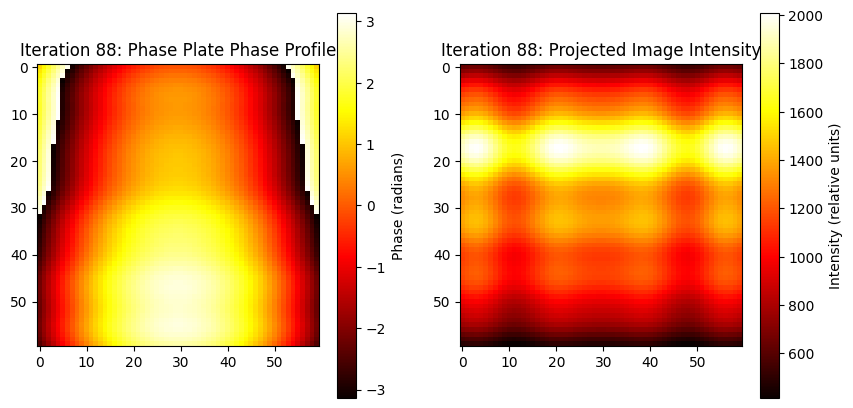

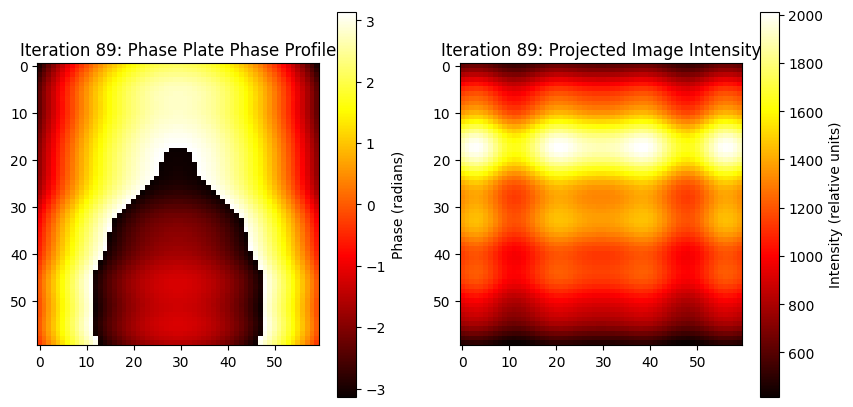

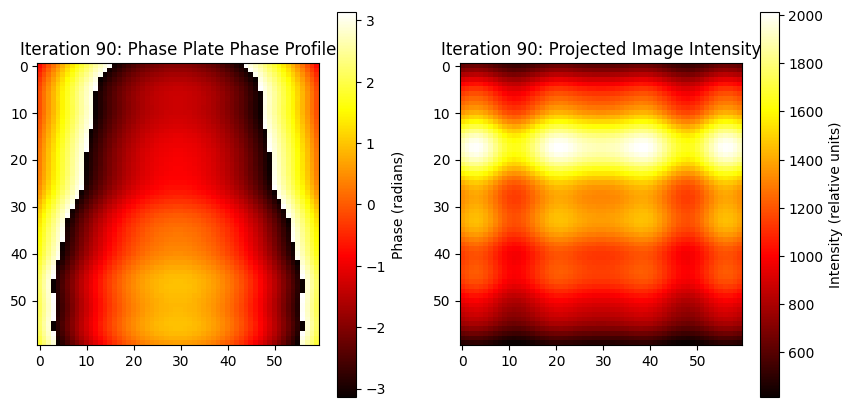

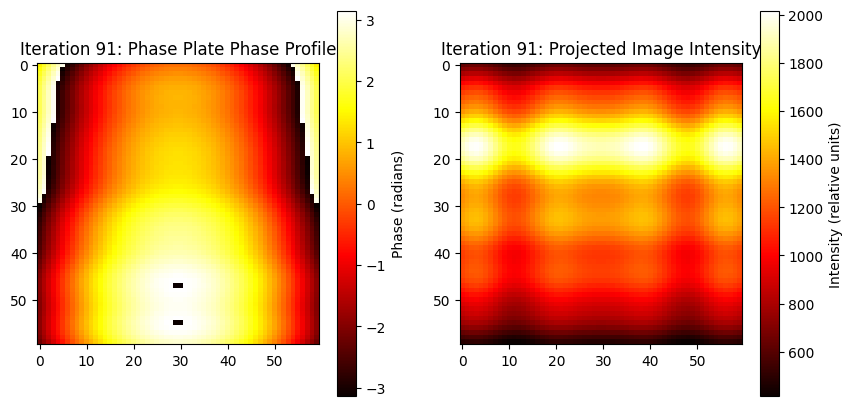

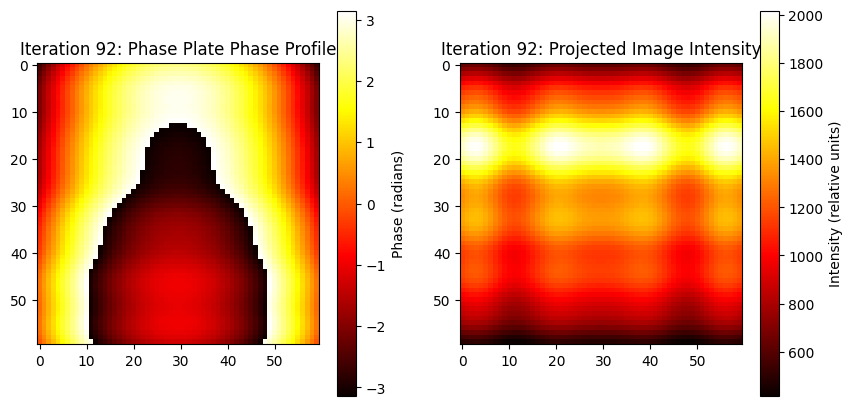

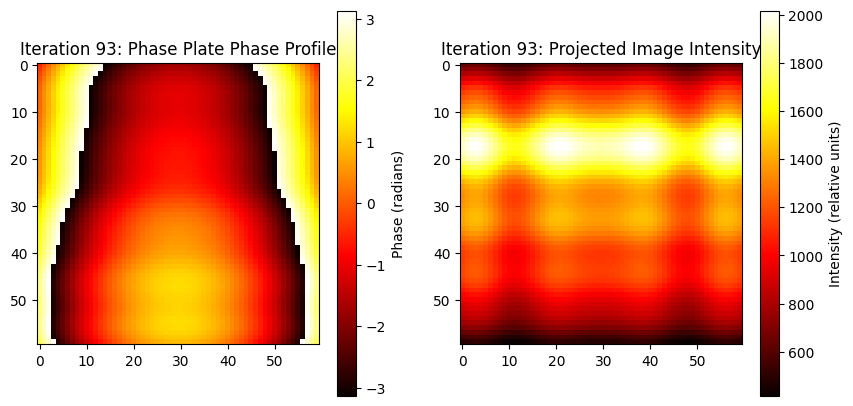

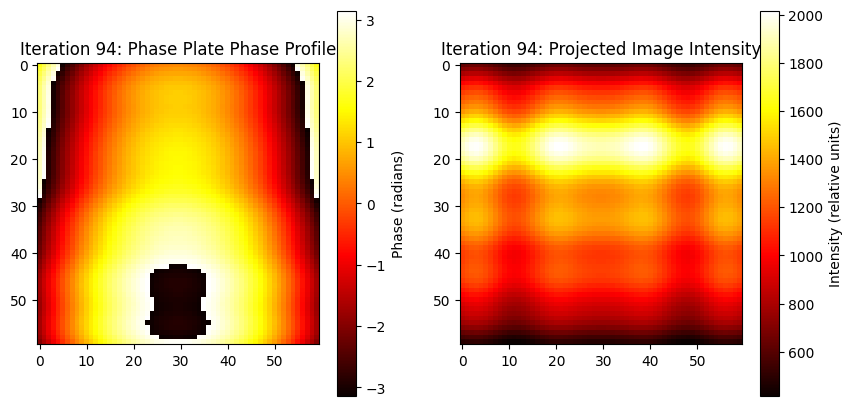

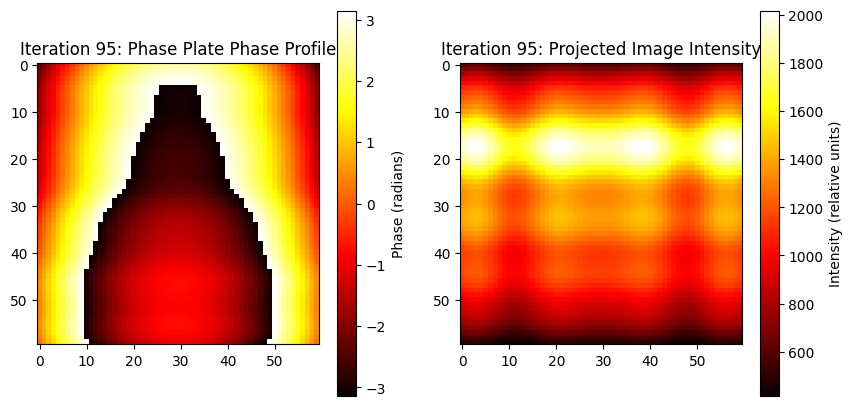

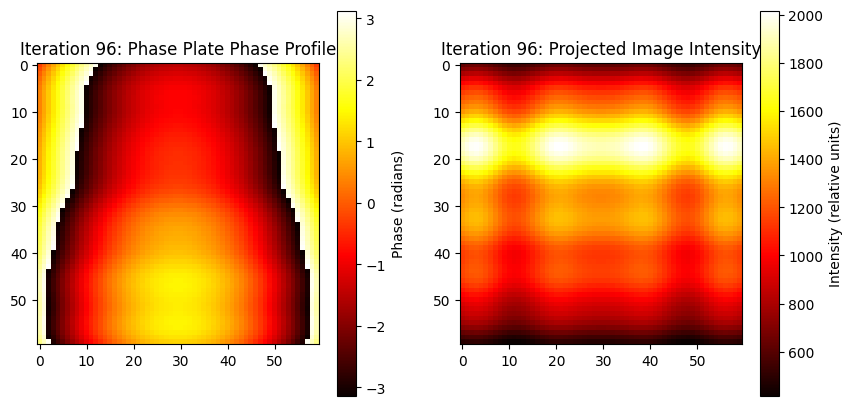

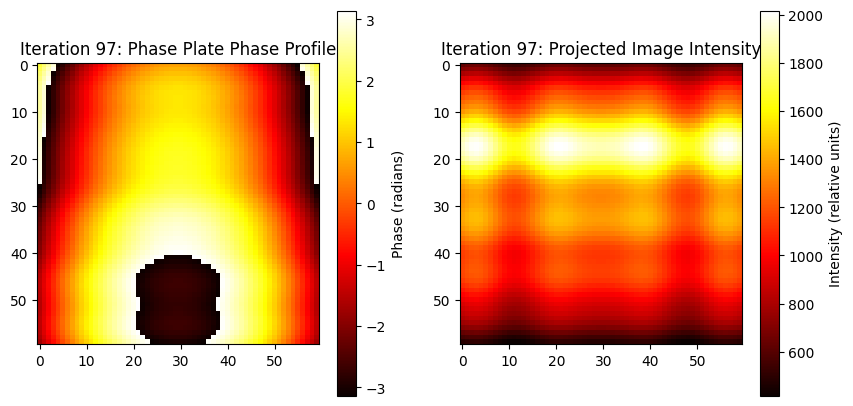

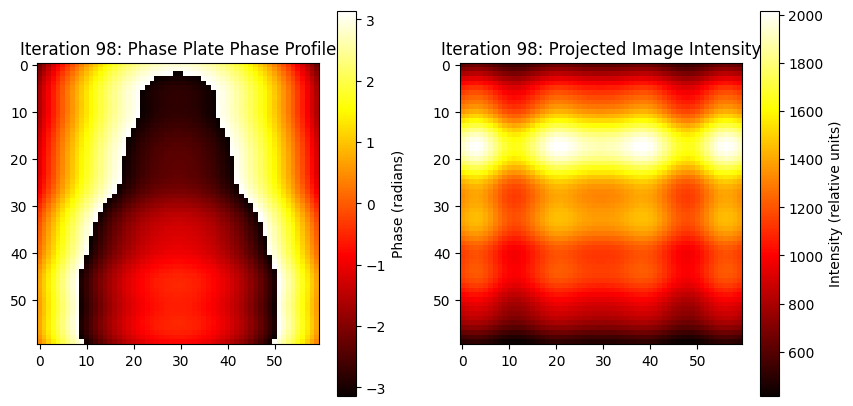

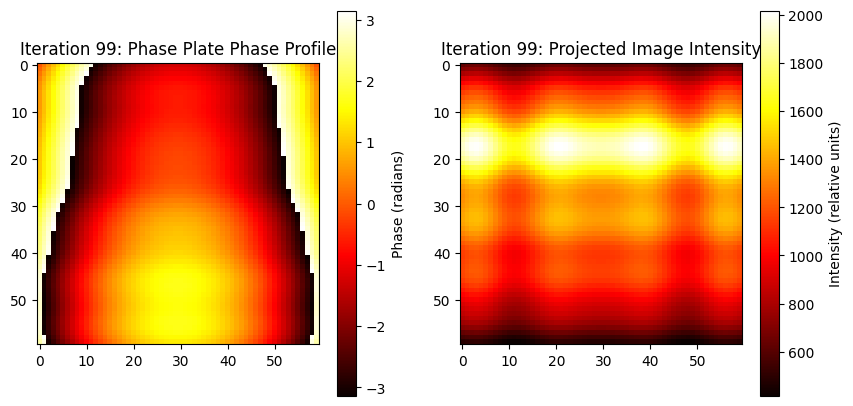

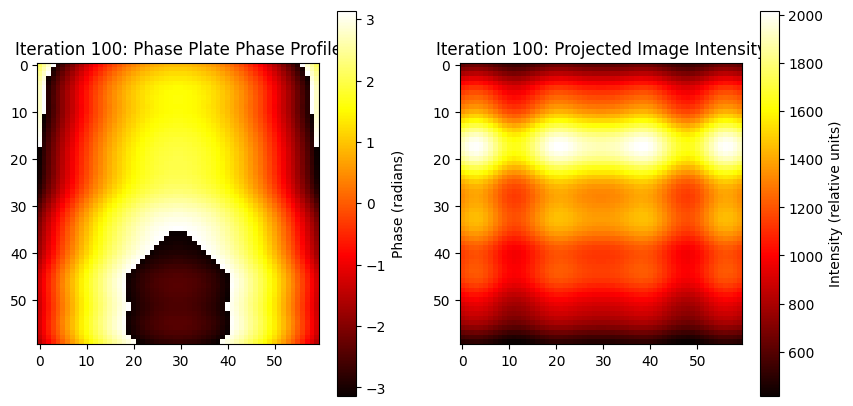

In [10]:
# Updated Gerchberg-Saxton algorithm with interference and visualization at each iteration
def gerchberg_saxton_interference_visual(E_initial, target_amp, X_plate, Y_plate, X_image, Y_image, distance, iterations):
    # Start with the initial field at the phase plate
    E_at_plate = E_initial  # Assume initial Gaussian profile
    
    # Loop over the number of iterations
    for i in range(iterations):
        # Step 1: Forward propagation to the image plane
        E_at_image = propagate_with_interference(E_at_plate, X_plate, Y_plate, X_image, Y_image, distance)
        
        # Step 2: Apply target amplitude constraint, keeping current phase
        phase_image = np.angle(E_at_image)
        E_at_image = np.abs(target_amp) * np.exp(1j * phase_image)
        
        # Step 3: Backward propagation back to the phase plate
        E_at_plate = back_propagate_with_interference(E_at_image, X_image, Y_image, X_plate, Y_plate, distance)
        
        # Step 4: Update the phase at the phase plate (keep initial amplitude, update phase)
        phase_plate = np.angle(E_at_plate)
        E_at_plate = np.abs(E_initial_intensity) * np.exp(1j * phase_plate)
        
        # Plotting the current phase profile and the projected image intensity
        plt.figure(figsize=(10, 5))
        
        # Left: Current phase profile at the phase plate
        plt.subplot(1, 2, 1)
        plt.imshow(phase_plate, cmap='hot')
        plt.title(f'Iteration {i+1}: Phase Plate Phase Profile')
        plt.colorbar(label='Phase (radians)')
        
        # Right: Projected image intensity in the target plane
        # Combine initial amplitude with final phase to get the final electric field at the phase plate
        E_phase_plate_current = np.abs(E_initial_intensity) * np.exp(1j * phase_plate)
        
        # Perform final propagation from phase plate to image plane to get the generated image
        E_generated_image = propagate_with_interference(E_phase_plate_current, X_plate, Y_plate, X_image, Y_image, distance)
        
        # Calculate intensity at the image plane
        intensity_generated_image = np.abs(E_generated_image)
        # epsilon = 1e-10
        # intensity_generated_image /= np.max(intensity_generated_image) + epsilon 
        
        # Normalize the intensity for visualization
        # intensity_generated_image /= np.max(intensity_generated_image)  # Scale to max intensity of 1
        
        plt.subplot(1, 2, 2)
        plt.imshow(intensity_generated_image, cmap="hot")
        plt.title(f'Iteration {i+1}: Projected Image Intensity')
        plt.colorbar(label='Intensity (relative units)')
        
        plt.show()
    
    # Return the final phase of the phase plate
    return phase_plate

# Run the Gerchberg-Saxton algorithm and visualize each iteration
iterations = 100
distance = distance_plate_to_image
final_phase_interference = gerchberg_saxton_interference_visual(E_initial, target_intensity, X_plate, Y_plate, X_image, Y_image, distance, iterations)


In [20]:
# to save the phase plate
np.save('final_phase_plate_horizontal_line.npy', final_phase_interference)

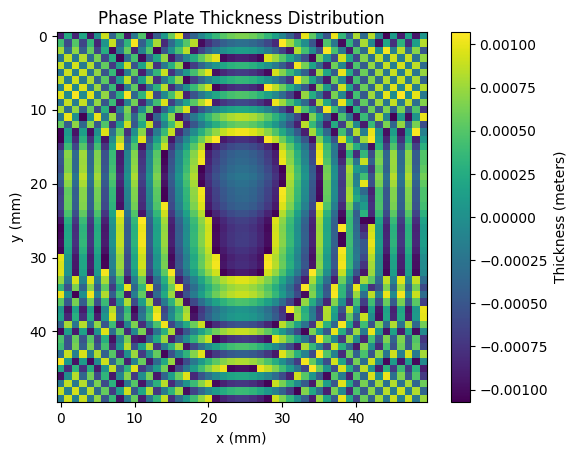

In [36]:
c = 3e8  # Speed of light in m/s
frequency = 200e9  # Frequency in Hz
wavelength = c / frequency

n = 1.7  # Refractive index of polyamide

# Calculate thickness distribution based on the final phase profile
thickness = (final_phase_interference * wavelength) / (2 * np.pi * (n - 1))

# Plot the thickness distribution
plt.imshow(thickness)
plt.title("Phase Plate Thickness Distribution")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Thickness (meters)")
plt.show()


[[0.00019896 0.00130588 0.00023315 ... 0.0012407  0.00013233 0.00112286]
 [0.00148755 0.00048602 0.00156673 ... 0.00027397 0.00120228 0.00190376]
 [0.00184609 0.00074485 0.0017788  ... 0.00076587 0.0017599  0.00058496]
 ...
 [0.0008645  0.00193888 0.00085747 ... 0.00185207 0.00070559 0.00166197]
 [0.00195423 0.00091866 0.00199668 ... 0.00088007 0.0018889  0.00071313]
 [0.00087608 0.00199064 0.00092894 ... 0.00197598 0.00084798 0.00182154]]


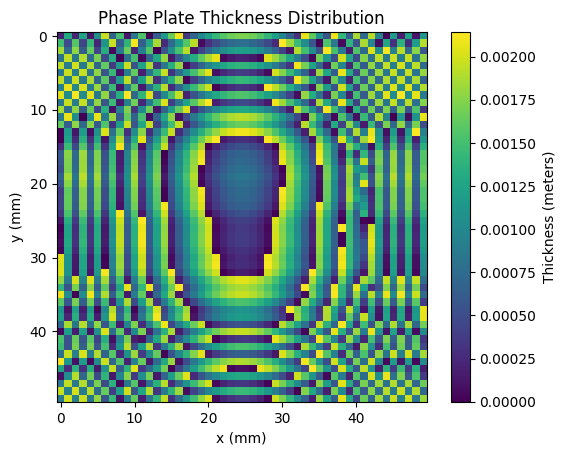

In [37]:
# Ensure all thickness values are non-negative
thickness -= np.min(thickness)

# Optionally scale the thickness values to match the printer's capability
# scale_factor = 10  # Scale factor to adjust dimensions appropriately
# thickness *= scale_factor

print(thickness)

# Plot the thickness distribution
plt.imshow(thickness)
plt.title("Phase Plate Thickness Distribution")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Thickness (meters)")
plt.show()

In [38]:
import trimesh

def generate_stl_from_thickness(thickness, x_range, y_range, filename="phase_plate.stl"):
    # Create a grid of x and y coordinates based on thickness map dimensions
    x = np.linspace(-x_range / 2, x_range / 2, thickness.shape[0])
    y = np.linspace(-y_range / 2, y_range / 2, thickness.shape[1])
    X, Y = np.meshgrid(x, y)
    
    # Create vertices in 3D space from the thickness data
    vertices = np.column_stack((X.ravel(), Y.ravel(), thickness.ravel()))
    
    # Generate faces (triangles) by connecting vertices
    faces = []
    for i in range(thickness.shape[0] - 1):
        for j in range(thickness.shape[1] - 1):
            # Define four corners of each grid square
            v1 = i * thickness.shape[1] + j
            v2 = v1 + 1
            v3 = v1 + thickness.shape[1]
            v4 = v3 + 1
            
            # Create two triangles for each square
            faces.append([v1, v3, v2])
            faces.append([v2, v3, v4])
    
    # Convert faces to numpy array
    faces = np.array(faces)
    
    # Create a mesh using trimesh
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    # Export to STL file
    mesh.export(filename)
    print(f"STL file saved as {filename}")

# Usage example with x_range and y_range of 100 mm (0.1 meters)
generate_stl_from_thickness(thickness, x_range=0.1, y_range=0.1, filename="phase_plate_horizontal_line_Nov16.stl")

STL file saved as phase_plate_horizontal_line_Nov16.stl


## OTHER TRIES

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Constants and initial parameters
c = 3e8  # Speed of light (m/s)
f = 200e9  # Frequency (Hz)
wavelength = c / f  # Wavelength (m)
beam_width = 80e-3  # Effective width of the Gaussian beam at the phase plate in meters
phase_plate_size = 0.1  # Phase plate size in meters (100 mm x 100 mm)
image_plane_size = 0.1  # Target image size in meters (500 mm x 500 mm)
distance_source_to_plate = 75e-3  # Distance from source to phase plate (in meters)
distance_plate_to_image = 500e-3  # Distance from phase plate to image plane (in meters)

# Set grid sizes for phase plate and image plane
grid_size_plate = 128  # Higher grid size for phase plate (100x100 mm)
grid_size_image = 128  # Higher grid size for image plane (500x500 mm)

# Spatial grid setup for the phase plate
x_plate = np.linspace(-phase_plate_size/2, phase_plate_size/2, grid_size_plate)
y_plate = np.linspace(-phase_plate_size/2, phase_plate_size/2, grid_size_plate)
X_plate, Y_plate = np.meshgrid(x_plate, y_plate)
R_plate = np.sqrt(X_plate**2 + Y_plate**2)

# Spatial grid setup for the image plane
x_image = np.linspace(-image_plane_size/2, image_plane_size/2, grid_size_image)
y_image = np.linspace(-image_plane_size/2, image_plane_size/2, grid_size_image)
X_image, Y_image = np.meshgrid(x_image, y_image)

# Updated Gaussian beam profile function with a larger beam width
def gaussian_beam_profile(X, Y, wavelength, beam_width, distance):
    phase_term = np.exp(1j * (2 * np.pi / wavelength) * (np.sqrt(distance**2 + X**2 + Y**2) - distance))
    amplitude_term = (1 / (2 * np.pi * beam_width**2)) * np.exp(-(X**2 + Y**2) / (4 * beam_width**2))
    return amplitude_term * phase_term

# Define initial Gaussian source amplitude
Source = gaussian_beam_profile(X_plate, Y_plate, wavelength, beam_width, distance_source_to_plate)
Source /= np.max(np.abs(Source))  # Normalize to max 1 for consistency

# Define a plus-shaped target amplitude profile in the image plane
target_amplitude = np.zeros((grid_size_image, grid_size_image))

# Define the dimensions of the plus shape
plus_width = 0.01  # Width of the plus arms (in meters)
plus_length = 0.05  # Length of the plus arms (in meters)

# Horizontal part of the plus
target_x = (np.abs(Y_image) <= plus_width / 2) & (np.abs(X_image) <= plus_length / 2)
# Vertical part of the plus
target_y = (np.abs(X_image) <= plus_width / 2) & (np.abs(Y_image) <= plus_length / 2)

# Combine to form the plus shape
target_amplitude[target_x | target_y] = 1
Target = target_amplitude  # Target amplitude for the desired image
Target /= np.max(Target)

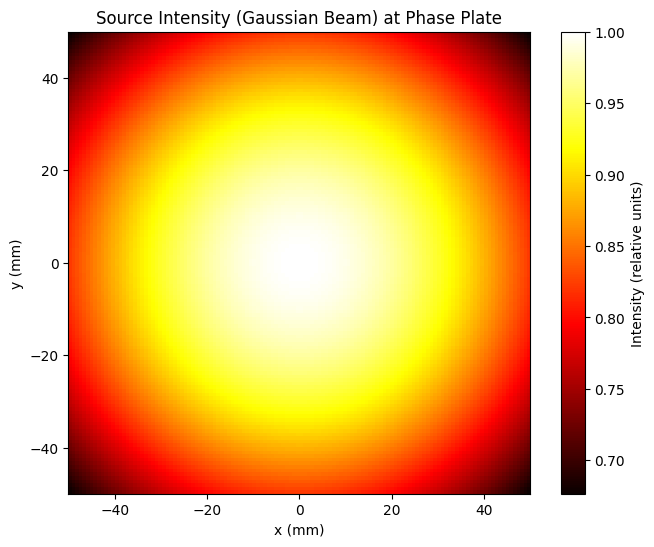

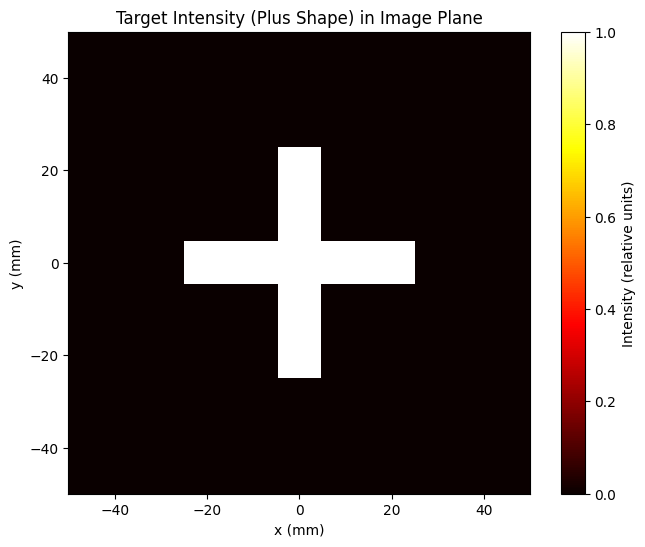

In [18]:
# Plot the source (initial Gaussian beam) intensity
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(Source)**2, extent=(-phase_plate_size/2*1e3, phase_plate_size/2*1e3, -phase_plate_size/2*1e3, phase_plate_size/2*1e3), cmap="hot")
plt.title("Source Intensity (Gaussian Beam) at Phase Plate")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity (relative units)")
plt.show()

# Plot the target (plus-shaped target image) intensity
plt.figure(figsize=(8, 6))
plt.imshow(Target, extent=(-image_plane_size/2*1e3, image_plane_size/2*1e3, -image_plane_size/2*1e3, image_plane_size/2*1e3), cmap="hot")
plt.title("Target Intensity (Plus Shape) in Image Plane")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity (relative units)")
plt.show()


In [19]:
# Define the quadratic phase term function
k = 2 * np.pi / wavelength  # Wave number

def quadratic_phase_term(X, Y, wavelength, z):
    return np.exp(1j * k * z) * np.exp(1j * np.pi * (X**2 + Y**2) / (wavelength * z))

Iteration 0: Error = 0.9950
Iteration 1: Error = 0.9957
Iteration 2: Error = 0.9958
Iteration 3: Error = 0.9959
Iteration 4: Error = 0.9959
Iteration 5: Error = 0.9955
Iteration 6: Error = 0.9958
Iteration 7: Error = 0.9959
Iteration 8: Error = 0.9958
Iteration 9: Error = 0.9956
Iteration 10: Error = 0.9957
Iteration 11: Error = 0.9957
Iteration 12: Error = 0.9958
Iteration 13: Error = 0.9961
Iteration 14: Error = 0.9960
Iteration 15: Error = 0.9959
Iteration 16: Error = 0.9960
Iteration 17: Error = 0.9958
Iteration 18: Error = 0.9958
Iteration 19: Error = 0.9959
Iteration 20: Error = 0.9962
Iteration 21: Error = 0.9958
Iteration 22: Error = 0.9959
Iteration 23: Error = 0.9960
Iteration 24: Error = 0.9956
Iteration 25: Error = 0.9958
Iteration 26: Error = 0.9956
Iteration 27: Error = 0.9959
Iteration 28: Error = 0.9960
Iteration 29: Error = 0.9958
Iteration 30: Error = 0.9959
Iteration 31: Error = 0.9958
Iteration 32: Error = 0.9959
Iteration 33: Error = 0.9957
Iteration 34: Error = 0.

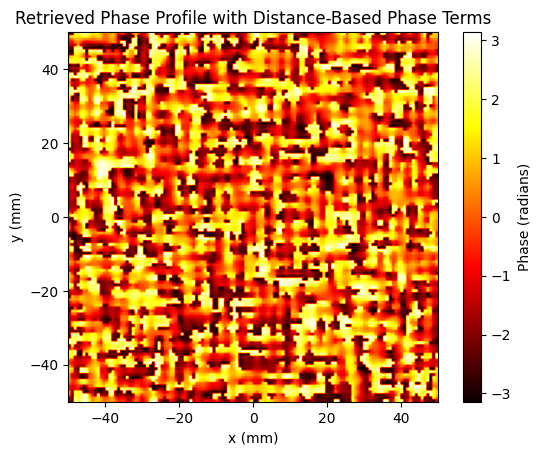

In [20]:
# Initialize A with the target amplitude and a random phase
random_phase = np.exp(1j * 2 * np.pi * np.random.rand(grid_size_plate, grid_size_plate))
A = Target[:grid_size_plate, :grid_size_plate] * random_phase

# Start the iterative Gerchberg-Saxton algorithm
iteration = 0
error_threshold = 0.80  # Higher initial threshold
max_iterations = 500
epsilon = 1e-10
error = float('inf')

while error > error_threshold and iteration < max_iterations:
    # Step 1: B := Amplitude(Source) × exp(i × Phase(A))
    B = np.abs(Source) * np.exp(1j * np.angle(A))
    
    # Step 2: C := FT(B) with distance-based phase for source-to-plate
    C = fftshift(fft2(ifftshift(B)))
    C *= quadratic_phase_term(X_plate, Y_plate, wavelength, distance_source_to_plate)

    # Step 3: D := Amplitude(Target) × exp(i × Phase(C))
    D = Target * np.exp(1j * np.angle(C))
    
    # Step 4: A := IFT(D) with distance-based phase for plate-to-image
    A = ifftshift(ifft2(fftshift(D * quadratic_phase_term(X_image, Y_image, wavelength, distance_plate_to_image))))
    
    # Calculate error as mean squared error within target region
    current_amplitude = np.abs(A)
    error_region = Target > 0  # Boolean mask for the target region
    error = np.mean((current_amplitude[error_region] - Target[error_region])**2) / (np.mean(Target[error_region]**2) + epsilon)
    
    print(f"Iteration {iteration}: Error = {error:.4f}")
    
    iteration += 1  # Increment iteration count

# Retrieve final phase profile
Retrieved_Phase = np.angle(A)

# Plot the final phase profile
plt.imshow(Retrieved_Phase, extent=(-phase_plate_size/2*1e3, phase_plate_size/2*1e3, -phase_plate_size/2*1e3, phase_plate_size/2*1e3), cmap="hot")
plt.title("Retrieved Phase Profile with Distance-Based Phase Terms")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Phase (radians)")
plt.show()

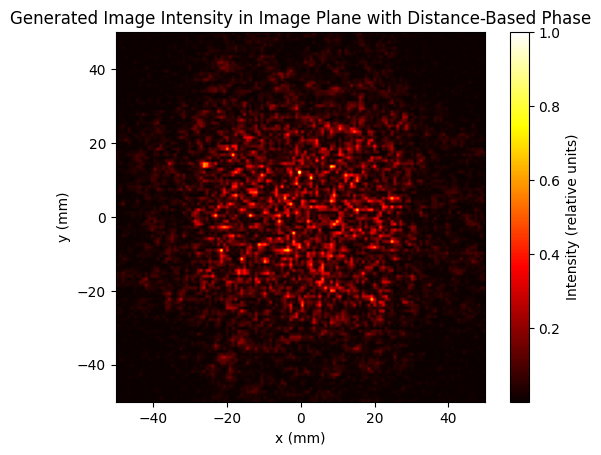

In [21]:
# Apply the phase plate to the initial Gaussian source
E_phase_plate = Source * np.exp(1j * Retrieved_Phase)

# Forward propagate to the image plane using Fourier transform and apply distance-based phase term
E_image_projected = fftshift(fft2(ifftshift(E_phase_plate)))
E_image_projected *= quadratic_phase_term(X_image, Y_image, wavelength, distance_plate_to_image)

# Calculate the intensity of the generated image
intensity_image_projected = np.abs(E_image_projected)**2
intensity_image_projected /= np.max(intensity_image_projected)  # Normalize for visualization

# Plot the generated image intensity
plt.imshow(intensity_image_projected, extent=(-image_plane_size/2*1e3, image_plane_size/2*1e3, -image_plane_size/2*1e3, image_plane_size/2*1e3), cmap="hot")
plt.title("Generated Image Intensity in Image Plane with Distance-Based Phase")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar(label="Intensity (relative units)")
plt.show()